# **WHAT MAKES AN AMAZON REVIEW HELPFUL?**

<img src='https://images.unsplash.com/photo-1523474253046-8cd2748b5fd2?q=80&w=1740&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D' width='400' alt='Amazon App'>

<!-- <img src='https://images.unsplash.com/photo-1704204656144-3dd12c110dd8?q=80&w=1709&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D' width='400'  alt='Amazon Logo'>

 -->


# Introduction

### Background

In 2024, the importance of E-commerce needs no explanation: titans like Shopify and Amazon account for hundreds of billions of dollars every year, and the convenience and ubiquity of online shopping have profoundly changed the retail industry forever. While consumer reviews have been part of the retail experience since its inception, the availability and immediacy of online reviews has made this take on a life of its own in the e-commerce era, with nearly all sellers providing reviews on the store page itself. Critically, these reviews are often anonymous or pseudo-anonymous; as a result, the financial incentives for having a well reviewed product (including fake reviews) have become a  source of major concern for buyers and platforms. One of the methods that platforms have used to distinguish reviews apart from another is by allowing a kind of **meta-review: the helpful review**!


### Objective


Even if there is a feature on an e-commerce site to signal that a review is helpful, it may not be fully adopted by all users reading reviews. Our underlying hypothesis is that **there are helpful reviews that are not voted as 'Helpful'**. We will attempt to incover these unlabeled helpful reviews and will do so for the company **Amazon** (the world's largest online retailer as per [Forbes](https://www.forbes.com/sites/laurendebter/2022/05/12/worlds-largest-retailers-2022-amazon-walmart-alibaba/?sh=4a491ab459e3)) as it's ubiquity can provide a rich dataset and it is the market leader, pushing innnovation in the domain of this project (e.g. the AI-powered [Customers Say Review Highlights](https://www.amazon.com/gp/help/customer/display.html?nodeId=G8UYX7LALQC8V9KA))


### Assumptions

We will assume the following:
- It is in Amazon's best interest to help users in their buying decision
- Reviews are an influential step in purchase consideration, but sifting thorough them is challenging.
- For e-commerce companies that allow user feedback in qualifying reviews as "helpful", these "helpful" reviews assist users in identifying relevant reviews and could be used as input for rank ordering reviews by the company.
- There is positive business impact in improving the process, primarily by reducing customer friction that could lead to a lost sale, hence increasing **conversion rate**

# Project Scope

### Data Available

We will use a [dataset of Amazon reviews from 2023](https://amazon-reviews-2023.github.io/) produced by the [Macauley Lab at UCSD](https://cseweb.ucsd.edu/~jmcauley/). The total data consists of nearly 600M rows, so inservice of scoping the project to a feasible plan, we intend to focus on **Home and Kitchen**, with **24M records** (though we intend to use a smaller random sample, depending on compute resources), as this offers an extremely high density of data and a few assumed properties:
- The category has a wide variety of brands and similar products
- We assume this category does not result in as many repeat purchases of the same item as others categories, increasing importance of reviews
- As many of these products are essential but NOT interchangeable household items, we assume buyers will be looking for signals of quality upon purchasing, increasing the importance of reviews


### Data Dictionary

User Reviews Dataset ([source](https://amazon-reviews-2023.github.io/))
- reviews (float): Rating of the product (from 1.0 to 5.0).
- title (str): Title of the user review.
- text (str): Text body of the user review.
- images (list): Images that users post after they have received the product. Each image has different sizes (small, medium, large), represented by the small_image_url, medium_image_url, and large_image_url respectively.
- asin (str): ID of the product.
- parent_asin (str): Parent ID of the product. Note: Products with different colors, styles, sizes usually belong to the same parent ID. The “asin” in previous Amazon datasets is actually parent ID. Please use parent ID to find product meta.
- user_id (str): ID of the reviewer
- timestamp (int):Time of the review (unix time)
- verified purchase (bool): User purchase verification
- helpful_vote(int): Helpful votes of the review

### Limitations

This project has the following limitations:
- Computing resources require sampling of the available data, which was already a small portion of all the available Amazon reviews.
- Due to time and resource limitations, we need to scope down the features being considered to those available in the User Reviews data described. There may be other features for Amazon to consider including (but not limited to): user properties, product metadata, quality of images, etc
- To limit data intake we will **only consider 2023 reviews**, the most recent data available. The 2023 data to be extracted only includes reviews **up to September 2023**. We expect first 9 months are a fair representation of yearly behavior.
- As most reviews are in English, this project **will only consider reviews in English**. Hence, insights presented here should only be applied to reviews in English.



# Initial Setup


In [1]:
# Should requirements.txt not be available, the following will generate a suitable
# requirements file:

f = open("requirements.txt", "a")
f.write('''requests
gdown
scipy
langdetect
imbalanced-learn
pandas
numpy
matplotlib
seaborn
gensim
nltk
textblob
scikit-learn
xgboost
''')
f.close()

In [2]:
# requirements.txt includes packages needed and can be modified to add new ones as needed

!python3 -m pip install -r requirements.txt

# lines below can be used to address error in import gensim >  ImportError: cannot import name 'triu' from 'scipy.linalg'

!python3 -m pip uninstall scipy --yes
!python3 -m pip cache purge
!python3 -m pip install scipy==1.12
import scipy
print(scipy.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=5708d85b2988e2ccccfddf60f06f2c9ccd96eb30d7df7bae12030053f711982e
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
Found existing installation: scipy 1.11.4
Uninstalling scipy-1.11.4:
  Successfully uninstalled scipy-1.11.4
Files removed: 40
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 21.8 MB/s eta 0:00:00
1.12.0


In [194]:
# Data Upload

import requests
import gzip
import json
import gdown
import io
import datetime

import random
# from google.colab import files

# Data Preprocessing
from scipy.stats import norm
from langdetect import detect
from imblearn.over_sampling import RandomOverSampler

# EDA
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
# from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns
from scipy.stats import linregress
from scipy.stats import ttest_ind

# Topic Modeling
import re
import gensim
from gensim import corpora, models
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Logistic Regression
from textblob import TextBlob
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, f1_score
import xgboost as xgb
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from xgboost import XGBClassifier



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# %%capture

# !apt install libkrb5-dev
# !wget https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
# !tar xf spark-3.1.2-bin-hadoop3.2.tgz
# !pip install findspark
# !pip install sparkmagic
# !pip install pyspark
# ! pip install pyspark --user
# ! pip install seaborn --user
# ! pip install plotly --user
# ! pip install imageio --user
# ! pip install folium --user

In [5]:
# import pyspark
# from pyspark.sql import SQLContext
# from pyspark.sql import SparkSession
# from pyspark.sql.types import *
# import pyspark.sql.functions as F

# spark = SparkSession.builder.getOrCreate()
# sqlContext = SQLContext(spark)

In [6]:
# %load_ext sparkmagic.magics

In [7]:
# # SQLite RDBMS
# import sqlite3

# import os
# os.environ['SPARK_HOME'] = '/content/spark-3.1.2-bin-hadoop3.2'
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# Data Upload and Preview

In this section, we will:


*   Upload a sample of the reviews data
*   Preview data to confirm it looks as expected, pending closer review in next section



The data, originally sourced from [THIS SITE](https://amazon-reviews-2023.github.io/) as described above, was saved in a Google Drive folder and given public access. It can now be retrieved with [THIS LINK](https://drive.google.com/file/d/1-ImOUcxWCSgsd1w01s7DdLXl35Tr9dcl/view) which will be used below.

**NOTE:** If automated download based on the linked data does not work (could happen if file used often), save data `.gz` file (Home and Kitchen Reviews) locally in same directory. This file can be downloaded by clicking [HERE](https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/review_categories/Home_and_Kitchen.jsonl.gz)

In [8]:
# download from public link file using gdown
try:
  print('Attempt File Intake via GDown')
  # link for .gz file in Google Drive link: https://drive.google.com/file/d/1-ImOUcxWCSgsd1w01s7DdLXl35Tr9dcl/view?usp=sharing (shared with anyone with a link)
  file_id = '1-ImOUcxWCSgsd1w01s7DdLXl35Tr9dcl'
  url = f'https://drive.google.com/uc?id={file_id}'
  output_file = 'Home_and_Kitchen.jsonl.gz'
  gdown.download(url, output_file, quiet=False)
  print('File Intake via GDown Success')

# if you can't use web version, upload from local file
except:
  print('Unable in injest from GDown')
  output_file = '/Home_and_Kitchen.jsonl.gz' # expects local execution with file in same folder

Attempt File Intake via GDown
Unable in injest from GDown


In [9]:
# DUPE OF ABOVE WITH SEPARATE URL FOR POST-CRASH ISSUES WITH GDOWN
#https://drive.google.com/file/d/1Z8-lvFpikjTEhgPCyRK8tKQy0b6WwIxP/view?usp=sharing
# download from public link file using gdown
try:
  print('Attempt File Intake via GDown')
  file_id = '1Z8-lvFpikjTEhgPCyRK8tKQy0b6WwIxP'
  url = f'https://drive.google.com/uc?id={file_id}'
  output_file = 'Home_and_Kitchen.jsonl.gz'
  gdown.download(url, output_file, quiet=False)
  print('File Intake via GDown Success')

# if you can't use web version, upload from local file
except:
  print('Unable in injest from GDown')
  output_file = '/Home_and_Kitchen.jsonl.gz' # expects local execution with file in same folder

Attempt File Intake via GDown


Downloading...
From (original): https://drive.google.com/uc?id=1Z8-lvFpikjTEhgPCyRK8tKQy0b6WwIxP
From (redirected): https://drive.google.com/uc?id=1Z8-lvFpikjTEhgPCyRK8tKQy0b6WwIxP&confirm=t&uuid=38e438a3-0f45-4312-9b41-897603532526
To: /content/Home_and_Kitchen.jsonl.gz
100%|██████████| 8.42G/8.42G [02:10<00:00, 64.7MB/s]

File Intake via GDown Success


Let's now extract the data needed. The data (in `.gz` file) just downloaded includes all the **Home and Kitchen** Amazon Reviews in the data sourced but we only want to **keep the 2023 data**.

Hence below, we will extract all the data for 2023. The date is in unix (as per the data dictionary section above). To convert it into a year, we can use the function [datetime.fromtimestamp](https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp) which expects the input in the unit seconds to turn into a date and then extract the year.

<!-- **NOTE (Limitation)**: Ingesting all 2023 reviews to then make a random sample of them would have been the best course of action, but due to RAM limitations, we will ingest only up to the sample_size desired. The code for the former will be available below for reference but commented. There is a potential risk in the data being ordered in a way that introduces bias. -->

In [10]:
# try-except-else to confirm the file downloaded is in the format expected
try:
    with gzip.open(output_file, 'rb') as f:
        f.read(1) # try to read first byte
        f.seek(0) # rewinds file pointer for next stage
except IOError:
    print(f"File '{output_file}' not in gzip format needed.")
else:
    # if reached, file in correct format, attemp data load into JSON
    json_reviews = {}
    with gzip.open(output_file, 'rb') as f: # with format, closes file upon finished
        i = 0
        for line in io.TextIOWrapper(f, encoding='utf-8'):
            json_data = json.loads(line.strip())
            # print(json_data)
            # print('timestamp' in json_reviews)

            # extract the year of the review
            if 'timestamp' in json_data:
              # extract year
              timestamp_s = json_data['timestamp'] / 1000 # converts to seconds
              review_date = datetime.datetime.fromtimestamp(timestamp_s)
              review_year = review_date.year

              # print(timestamp_s)
              # print(review_date)
              # print(review_year)

              # save 2023 year only
              if review_year == 2023:
                json_data['date'] = review_date # saved the date for future use
                json_reviews[i] = json_data
                i += 1


In [11]:
json_reviews[0]

{'rating': 1.0,
 'title': 'Received Used & scratched item! Purchased new!',
 'text': 'Livid.  Once again received an obviously used item that has food on it & scratches. I purchased this new!!  Pics not loading rn. Will add them later. Disgusted.',
 'images': [],
 'asin': 'B007WQ9YNO',
 'parent_asin': 'B09XWYG6X1',
 'user_id': 'AFKZENTNBQ7A7V7UXW5JJI6UGRYQ',
 'timestamp': 1677373409298,
 'helpful_vote': 1,
 'verified_purchase': True,
 'date': datetime.datetime(2023, 2, 26, 1, 3, 29, 298000)}

In [12]:
len(json_reviews)

4000728

**Sample Size**: This review set is large enough that performing complex operations on it is very slow, and capable of exceeding even very advanced RAM requirements, so we will generate a random sample of 100,000 elements below. This decision is arbitrary, but represents about 2.5% of the available data, and is sufficiently large that we can have faith that our analysis will be robust. For randomization, we will use Python's [random.seed](https://docs.python.org/3/library/random.html) so that upon this note's reproductions, the same elements are selected.

In [13]:
# what data size to keep?
sample_size = 100000

In [14]:
# sets the random seed described above
random.seed(5450)

In [15]:
# extract keys
json_reviews_keys = list(json_reviews.keys()) # expect range(0, len(json_reviews)-1)

In [16]:
json_reviews_keys_random = random.sample(json_reviews_keys, sample_size)

In [17]:
# new dictionary with just the sample
json_reviews_sample = {key: json_reviews[key] for key in json_reviews_keys_random }

In [18]:
len(json_reviews_sample)

100000

In [19]:
# preview an element

json_reviews_sample[list(json_reviews_sample.keys())[0]] # may no longer have key of 0 so extracting keys as a list and picking 1

{'rating': 5.0,
 'title': 'Beautiful and excellent quality',
 'text': "I purchased these to add to my wreaths.  These are excellent quality, the nicest eucalyptus I've purchased to date.  I will send photo when my wreath is complete.  They look real! I was so pleased with them that I ordered 2 more sets.",
 'images': [],
 'asin': 'B07RX6R5VV',
 'parent_asin': 'B0989WY2J3',
 'user_id': 'AE37EBBRGEBCRZEZKFEABFGSSJNA',
 'timestamp': 1690903497887,
 'helpful_vote': 0,
 'verified_purchase': True,
 'date': datetime.datetime(2023, 8, 1, 15, 24, 57, 887000)}

Now, that the desired data is saved in the dictionary `json_reviews_sample`, we can format this data as a dataframe. Once the dataframe is ready, we can discard the helper dictionaries `json_reviews` and `json_reviews_sample` used in this section as they won't be needed in future sections and are large files with a meaningful impact on our runtime environment.

In [20]:
raw_reviews = pd.DataFrame.from_dict(json_reviews_sample, orient='index')
raw_reviews.reset_index(drop=True, inplace=True) # update to 0 indexing, instead of the keys in the json

# preview data
raw_reviews.head(2)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,date
0,5.0,Beautiful and excellent quality,I purchased these to add to my wreaths. These...,[],B07RX6R5VV,B0989WY2J3,AE37EBBRGEBCRZEZKFEABFGSSJNA,1690903497887,0,True,2023-08-01 15:24:57.887
1,5.0,Easy,Work the best,[],B07F81MGRZ,B07F81MGRZ,AEW3IPFQX64JZXPRANQJVDPUN5LA,1680701883880,0,True,2023-04-05 13:38:03.880


In [21]:
# delete uneeded resources
del json_reviews
del json_reviews_sample

In [22]:
# raise Exception("Stop: End of Data Upload")

We have reached the conclusion of data input, a dataframe with the sample reviews we were looking for

# Data Preprocessing

In this section, we will proprocess our reviews dataset with checks for: **nulls, wrong data types**, and any else that may come up. This area will contain the first steps in feature engineering.


In [65]:
# input raw_reviews from data upload
# output here: reviews = a dataframe ready for EDA

# start with copying raw_reviews from section above. This new df will undergo changes
reviews = raw_reviews.copy()

In [75]:
reviews.head(5)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,date
0,5.0,Beautiful and excellent quality,I purchased these to add to my wreaths. These...,[],B07RX6R5VV,B0989WY2J3,AE37EBBRGEBCRZEZKFEABFGSSJNA,1690903497887,0,True,2023-08-01 15:24:57.887
1,5.0,Easy,Work the best,[],B07F81MGRZ,B07F81MGRZ,AEW3IPFQX64JZXPRANQJVDPUN5LA,1680701883880,0,True,2023-04-05 13:38:03.880
2,5.0,Just adorable!!!,Perfect!!!! Love it!,[],B07L2ZN72G,B07S24FWK6,AEH54RPJ6ECAKUEII2FEYP2CH3SA,1678336398705,0,True,2023-03-09 04:33:18.705
3,5.0,Wonderful Scent and Long-lasting,"It was packaged nicely, shipping time was supe...",[],B06XGSGY1F,B09HWWT9SW,AHQWKPZTNWU43OUKPWILAS6OYF7A,1679592532452,1,True,2023-03-23 17:28:52.452
4,2.0,Makes an unpleasant sound when grinding,The first couple of times I used this it work...,[],B08RRVNFQL,B09C7XN3C9,AHSAX73NEBBLDPXAUIPRQN4QSVUQ,1680121768706,0,True,2023-03-29 20:29:28.706


Based on the first 5 rows, the data looks much as we'd expect. The titles and text are complete and readable, the identification numbers are exactly that, the user_ids look like unique values, the timestamps are timestamps, and we have a helpful vote counter. Notably, the images look like an empty collection represented as a string, and the helpful votes take only binary values.



In [79]:
reviews['helpful_vote'].value_counts().head(5)

helpful_vote
0    80842
1    11977
2     3529
3     1390
4      757
Name: count, dtype: int64

In [81]:
reviews.loc[reviews['images'].str.len() > 2, 'images'].head(2)

76    [{'small_image_url': 'https://m.media-amazon.c...
82    [{'small_image_url': 'https://m.media-amazon.c...
Name: images, dtype: object

So in fact those columns do appear to be as expected, and the header just happened to display a certain set of values. So all looks in order.

### Checking for missing values
Next let's evaluate for missing, null, or otherwise invalid data.

In [71]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             100000 non-null  float64       
 1   title              100000 non-null  object        
 2   text               100000 non-null  object        
 3   images             100000 non-null  object        
 4   asin               100000 non-null  object        
 5   parent_asin        100000 non-null  object        
 6   user_id            100000 non-null  object        
 7   timestamp          100000 non-null  int64         
 8   helpful_vote       100000 non-null  int64         
 9   verified_purchase  100000 non-null  bool          
 10  date               100000 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 7.7+ MB


Conveniently, there aren't any null values! The data appears to be a plausible representation of the population of amazon reviews, and was clearly carefully collected and collated.

### Deduplication
Now let's look at **duplicates**. As images is an array, we can't use drop_duplicates on the entire dataframe. However, we can probably conclude that cases where a single user makes multiple submissions with completely identical timestamps for the exact same product are NOT genuinely unique.

In [82]:
# how much will stay after
duplicate_check_cols = ['user_id', 'timestamp', 'parent_asin', 'asin']
len(reviews.drop_duplicates(subset=duplicate_check_cols))

99954

Fortunately, this is quite rare. Only 56 records are impacted. Since this will not compromise the integrity of our data, let's go ahead and filter those out.

In [85]:
reviews.drop_duplicates(subset=duplicate_check_cols, inplace=True)
len(reviews)


99954

### Data Types
We are de-duped and require zero imputation (as a result of no-nulls). At this point, let's review the data types of in our dataframe.

In [30]:
reviews.dtypes

rating                      float64
title                        object
text                         object
images                       object
asin                         object
parent_asin                  object
user_id                      object
timestamp                     int64
helpful_vote                  int64
verified_purchase              bool
date                 datetime64[ns]
dtype: object

The string columns are correctly identified, so let's take a closer look at the numeric ones and boolean ones below.

In [86]:
# Rating
reviews['rating'].value_counts(normalize=True)

rating
5.0    0.641025
1.0    0.126658
4.0    0.104708
3.0    0.072533
2.0    0.055075
Name: proportion, dtype: float64

For rating, we know there are not nulls and the data will be an integer 1-5, so let's cast accordingly.

In [89]:
# change to integer as decimal is unecessary information

reviews['rating'] = reviews['rating'].astype(int)

In [90]:
reviews['rating'].dtypes

dtype('int64')

### Dates and cyclicality

 Let's now consider the `timestamp` and `date` columns. The first can be dropped right away as it is redundant. For the latter, let's break it apart into some interesting components.

**NOTE**: As timestamp was in unix and we don't have each user's timezone, we will assume there is no way to know the individual local time. Hence, we will not use hour. Some of those differences would be slightly less marked in day of the week and month. *For `dt.dayofweek`, the days are denoted by 0-6 based on Monday-Sunday ([src](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.dayofweek.html))*

In [91]:
# drop timestamp
len(reviews.columns)

11

In [92]:
reviews.drop(columns=['timestamp'], inplace=True)
len(reviews.columns)

10

In [93]:
# preview date
reviews['date'].head(4)

0   2023-08-01 15:24:57.887
1   2023-04-05 13:38:03.880
2   2023-03-09 04:33:18.705
3   2023-03-23 17:28:52.452
Name: date, dtype: datetime64[ns]

The day of week data looks plausible, with a monotonic relationship between review activity that monotonically decreases as we move through the week.

In [94]:
reviews['dow'] = reviews['date'].dt.dayofweek
reviews['dow'].value_counts(normalize=True)

dow
0    0.153841
1    0.150799
2    0.148688
3    0.142756
6    0.137303
4    0.134952
5    0.131661
Name: proportion, dtype: float64

The month data is a little more unevenly distributed, and at first the disparity might seem concerning, but this is intuitively reasonable. Without available Q4 data, we're forced to speculate, but it seems plausible that the bulk of amazon purchases occur in the final four months of the year (and certainly [Amazon's earnings reports seem to validate this](https://ir.aboutamazon.com/news-release/news-release-details/2024/Amazon.com-Announces-Fourth-Quarter-Results/default.aspx)) and a flurry of review activity occurs in response to the massive upward tick in sales in this category and dies off as the year goes on (and consider that September breaks this relationship, as we have less than a third of the data available from that month, since our data ends on September 9th, which also fits with our idea that amazon's retail business is busiest at the end of the year). So this looks in order.

In [97]:
reviews['month'] = reviews['date'].dt.month
reviews['month'].value_counts(normalize=True)

month
1    0.265462
3    0.227505
2    0.200042
4    0.126678
5    0.069042
6    0.046001
7    0.037597
8    0.025992
9    0.001681
Name: proportion, dtype: float64

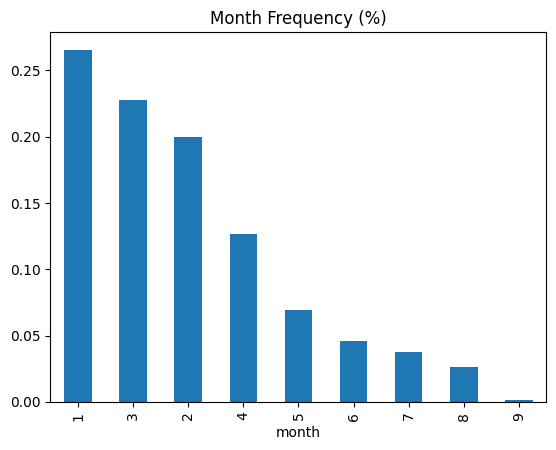

In [98]:
reviews['month'].value_counts(normalize=True).plot.bar().set_title('Month Frequency (%)');

**NOTE (Limitation):** We dont have data for all 2023. The data does not go past September 9th. We will be under the assumption the months left are representative of the patterns for the year.

In [99]:
# drop date
len(reviews.columns)

12

In [41]:
reviews.drop(columns=['date'], inplace=True)
len(reviews.columns)

11

A longitudinal view across nine months is probably insufficient to draw any conclusions, so we can drop timestamp and date columns, but the day-of-week and  month-of-year columns seem interesting.

Finally, let's consider the verified purchase boolean (which we leave as a bool type for now).

In [100]:
# verified purchase
reviews['verified_purchase'].value_counts(normalize=True)

verified_purchase
True     0.868229
False    0.131771
Name: proportion, dtype: float64

In [101]:
# helpful_vote
reviews['helpful_vote'].nunique()

60

In [102]:
# What is the distribution
reviews['helpful_vote'].value_counts(normalize=True).head(20)

helpful_vote
0     0.808792
1     0.119825
2     0.035306
3     0.013906
4     0.007573
5     0.003932
6     0.002701
7     0.001461
8     0.001281
9     0.000930
10    0.000610
11    0.000540
12    0.000460
13    0.000360
14    0.000320
15    0.000230
16    0.000230
18    0.000210
17    0.000190
20    0.000160
Name: proportion, dtype: float64

In [103]:
reviews['helpful_vote'].value_counts(normalize=True).head(3).sum()

0.9639234047661924

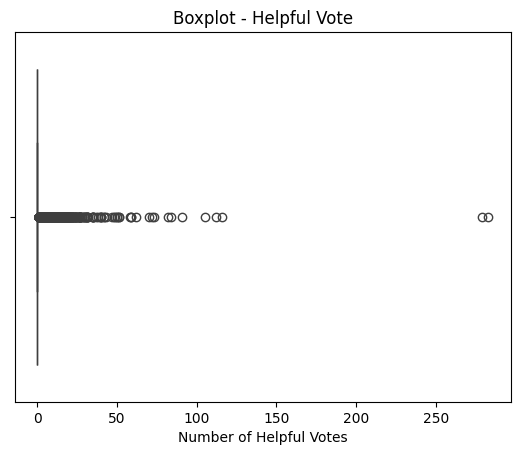

In [104]:
sns.boxplot(x=reviews['helpful_vote'])
plt.xlabel('Number of Helpful Votes')
plt.title('Boxplot - Helpful Vote');

For `helpful_vote`, it is important to note this field is highly skewed. With **~80% of reviews having 0 votes** as a helpful review and **~96% reviews having 3 or less**. We can see via the boxplot above, this data has outliers.

To improve usability, let's extract a boolean of being marked at all helpful vs and consider outliers based z-test with a 95% confidence interval.


<!-- For **extracting outliers**, we will use a simple process based on z-scores on a 95% confidence interval. -->

In [105]:
reviews['is_helpful'] = reviews['helpful_vote'] > 0
reviews['is_helpful'].value_counts(normalize=True)

is_helpful
False    0.808792
True     0.191208
Name: proportion, dtype: float64

In [106]:
# Look for outliers based on 95% confidence interval.

confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)

helpful_vote_mean = reviews['helpful_vote'].mean()
helpful_vote_std = reviews['helpful_vote'].std()

lower_bound = helpful_vote_mean - z_score * helpful_vote_std
upper_bound = helpful_vote_mean + z_score * helpful_vote_std

# identify outliers

outliers = reviews[(reviews['helpful_vote'] < lower_bound) | (reviews['helpful_vote'] > upper_bound)].index
perc_outliers = len(outliers) / len(reviews) * 100
perc_outliers

1.4596714488664786

In [107]:
len(outliers)

1459

In [108]:
# Assuming all outliers in True, how much of the True would be dropped?
len(outliers) / len(reviews.loc[reviews['is_helpful'] == True])

0.07633947258267057

Although there are outliers, we will keep them as the data is unbalanced and they are all in our minority class, corresponding to 7.5% of it.


We have extracted our possible target is_helpful. For now, we will keep is_helpful and helpful_vote for EDA but the latter must be removed before any modeling to avoid data leakage.

Now. let's get a glimpse on our string columns: title, text, images, asin, parent_asin, user_id

In [109]:
reviews['title'].head(2)

0    Beautiful and excellent quality
1                               Easy
Name: title, dtype: object

In [110]:
reviews['title_length'] = reviews['title'].str.strip().str.len() # remove leading and trailing spaces before
reviews['title_length'].head(5)

0    31
1     4
2    16
3    32
4    39
Name: title_length, dtype: int64

In [111]:
# any reviews without a title once .strip() applied? No
len(reviews.loc[reviews['title_length'] == 0])

0

In [112]:
reviews['title_length'].value_counts()

title_length
12     5093
9      4756
11     4607
13     4517
10     4259
       ... 
91       33
99       31
92       31
94       30
100      23
Name: count, Length: 100, dtype: int64

In [113]:
reviews['text'].head(2)

0    I purchased these to add to my wreaths.  These...
1                                        Work the best
Name: text, dtype: object

In [114]:
#reviews['text_length'] = reviews['text'].str.strip().str.len() # remove leading and trailing spaces before
reviews['text_length'] = reviews['text'].str.strip().str.len() # remove leading and trailing spaces before
reviews['text_length'].head(5)

0    234
1     13
2     20
3     86
4    529
Name: text_length, dtype: int64

In [115]:
# any reviews without a text once .strip() applied? No
len(reviews.loc[reviews['text_length'] == 0])

579

In [116]:
reviews['is_blank_review'] = reviews['text_length'] == 0
reviews['is_blank_review'].value_counts(normalize=True)

is_blank_review
False    0.994207
True     0.005793
Name: proportion, dtype: float64

We have reviewed the columns for title and text. Let's consider what to do with the rest.

For user_id, let's extract a column indicating repeat reviewers but otherwise remove it.

**NOTE:** An analysis looking at the review patters of reviewers could be a great next step for this analysis.

In [117]:
# any repeat reviewers?
reviews['user_id'].nunique()

94842

In [118]:
# most users are one time reviewers, but about 9% review more than once

reviews['reviews_per_user'] = reviews.groupby('user_id')['user_id'].transform('count')
reviews['reviews_per_user'].value_counts()

reviews_per_user
1     91063
2      5828
3      1683
4       832
5       270
6       168
7        42
8        40
9        18
10       10
Name: count, dtype: int64

In [119]:
# drop user_id
len(reviews.columns)

17

In [120]:
reviews.drop(columns=['user_id'], inplace=True)
len(reviews.columns)

16

We are done with user_id. Let's consider ASIN, or "Amazon Standard Identification Number", which, per [Amazon's website](https://developer.amazon.com/docs/mobile-associates/mas-finding-product-id.html), is Amazon's equivalent of a product SKU tag. For the ASIN columns, we know that each `parent_asin` value has multiple children `asin` when there are variaties of the product. Let's extract the reviews for products with reviews for different variants.

In [121]:
reviews['has_variant_reviews'] = reviews.groupby('parent_asin')['asin'].transform(lambda x: len(x.unique()) > 1)
reviews['has_variant_reviews'].value_counts(normalize=True)

has_variant_reviews
False    0.690167
True     0.309833
Name: proportion, dtype: float64

Within this project scope, we will not ingest product metadata to focus on the review features themselves. We will keep `asin` for a future section but can remove `parent_asin`

In [122]:
# drop parent_asin, asin
len(reviews.columns)

17

In [123]:
reviews.drop(columns=['parent_asin'], inplace=True)
len(reviews.columns)

16

### Image

Let's finally consider some interesting properties of image. Let's follow from our earlier logic and build a boolean column which specifies whether or not a non-zero number of images were attached to the review.

In [124]:
reviews['images'].head(2)

0    []
1    []
Name: images, dtype: object

In [125]:
#images
reviews['has_image'] = reviews['images'].str.len() > 0
reviews['has_image'].value_counts(normalize=True)

has_image
False    0.850841
True     0.149159
Name: proportion, dtype: float64

In [126]:
reviews.loc[reviews['has_image'] == True]['images'].head(1)

45    [{'small_image_url': 'https://m.media-amazon.c...
Name: images, dtype: object

If we check for validity, it seems to match our expectations.

In [127]:
# preview
for x in reviews.loc[reviews['has_image'] == True]['images'].head(5):
  print(x)

[{'small_image_url': 'https://m.media-amazon.com/images/I/711dKpG2S3L._SL256_.jpg', 'medium_image_url': 'https://m.media-amazon.com/images/I/711dKpG2S3L._SL800_.jpg', 'large_image_url': 'https://m.media-amazon.com/images/I/711dKpG2S3L._SL1600_.jpg', 'attachment_type': 'IMAGE'}]
[{'small_image_url': 'https://m.media-amazon.com/images/I/71W1v+y6JwL._SL256_.jpg', 'medium_image_url': 'https://m.media-amazon.com/images/I/71W1v+y6JwL._SL800_.jpg', 'large_image_url': 'https://m.media-amazon.com/images/I/71W1v+y6JwL._SL1600_.jpg', 'attachment_type': 'IMAGE'}, {'small_image_url': 'https://m.media-amazon.com/images/I/81dkkNOuf7L._SL256_.jpg', 'medium_image_url': 'https://m.media-amazon.com/images/I/81dkkNOuf7L._SL800_.jpg', 'large_image_url': 'https://m.media-amazon.com/images/I/81dkkNOuf7L._SL1600_.jpg', 'attachment_type': 'IMAGE'}]
[{'small_image_url': 'https://m.media-amazon.com/images/I/51xRlZoNztL._SL256_.jpg', 'medium_image_url': 'https://m.media-amazon.com/images/I/51xRlZoNztL._SL800_.jpg

Next we can easily count the images themselves, thanks to the way the array of dictionaries is structured.

In [128]:
reviews['num_images'] = reviews['images'].apply(len)
reviews['num_images'].value_counts(normalize=True).head(10)


num_images
0    0.850841
1    0.088601
2    0.032925
3    0.014397
4    0.006763
5    0.002951
6    0.001561
7    0.000980
8    0.000370
9    0.000250
Name: proportion, dtype: float64

In [129]:
# reviews['images_dict'] = reviews['images'].apply(lambda lst: lst[0] if lst else {})
# reviews['images_dict']

Final we can evaluate whether or not there is a non-image attachment.

In [130]:
# any with a value outside of image in attachment_type
reviews['has_non_image_attachment'] = reviews['images'].apply(lambda lst: any('attachment_type' in img and img['attachment_type'] != 'IMAGE' for img in lst))
reviews['has_non_image_attachment'].value_counts()

has_non_image_attachment
False    99954
Name: count, dtype: int64

Finding no examples in our data, let's delete this column.

In [132]:
del reviews['has_non_image_attachment']

KeyError: 'has_non_image_attachment'

In [ ]:
# drop images
len(reviews.columns)

In [133]:
reviews.drop(columns=['images'], inplace=True)
len(reviews.columns)

17

In [134]:
# is has_image now redundant??? if num_images === 0 is the same, then yes
len(reviews.loc[reviews['has_image'] == False]) == len(reviews.loc[reviews['num_images'] == 0])

True

In [135]:
# drop has_image
len(reviews.columns)

17

In [136]:
reviews.drop(columns=['has_image'], inplace=True)
len(reviews.columns)

16

### Filtering to English Language Reviews
Since a substantial portion of our project is based on text, but we are not told the language of a given review. Hence, we will have to implement a way to detect (as accurately as possible) the **text is in English**.

Fortunately, we can leverage the existing [langdetect](https://pypi.org/project/langdetect/) library which is a "direct port of Google's [language-detection library](https://code.google.com/archive/p/language-detection/) from Java to Python".

**NOTE (Limitation)**: Insights applicable for English-language reviews only

In [137]:
def detect_english(text):
    if len(text) < 3:
        return 'N/A'
    try:
        return detect(text) == 'en'
    except:
        return 'N/A'

reviews['is_english'] = np.where(reviews['is_blank_review'], True, reviews['text'].apply(detect_english))
reviews['is_english'].value_counts(normalize=True)

is_english
True     0.945985
False    0.052724
N/A      0.001291
Name: proportion, dtype: float64

In [138]:
reviews['is_english'].value_counts()

is_english
True     94555
False     5270
N/A        129
Name: count, dtype: int64

In [139]:
# drop non-English
len(reviews)

99954

In [140]:
reviews = reviews.loc[reviews['is_english'] == True]
len(reviews)

94555

In [141]:
# drop extra is_english column no longer needed
len(reviews.columns)

17

In [142]:
reviews.drop(columns=['is_english'], inplace=True)
len(reviews.columns)

<ipython-input-142-62840ed0e64b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews.drop(columns=['is_english'], inplace=True)


16

We were able to identify over 90% of the reviews are with some certainly in English and the rest are either not or we don't know. Non-English reviews were dropped

We have now reached the end of data preprocessing. We have checked for nulls, fixed data types, added features while removing excess info, and did a sanity check on the data seen. Everything appears in order.

In [143]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94555 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   rating               94555 non-null  int64         
 1   title                94555 non-null  object        
 2   text                 94555 non-null  object        
 3   asin                 94555 non-null  object        
 4   helpful_vote         94555 non-null  int64         
 5   verified_purchase    94555 non-null  bool          
 6   date                 94555 non-null  datetime64[ns]
 7   dow                  94555 non-null  int32         
 8   month                94555 non-null  int32         
 9   is_helpful           94555 non-null  bool          
 10  title_length         94555 non-null  int64         
 11  text_length          94555 non-null  int64         
 12  is_blank_review      94555 non-null  bool          
 13  reviews_per_user     94555 non-null 

Save a local copy if needed


In [144]:
# create folter if needed
file_name = 'reviews_out.csv'
reviews.to_csv(file_name, index=False)

In [145]:
# raise Exception("Stop: End of Data Preprocessing")

# Exploratory Data Analysis

Let's review our dataframe as it is now.

In [162]:
reviews_eda = reviews.copy()

In [163]:
reviews_eda.columns

Index(['rating', 'title', 'text', 'asin', 'helpful_vote', 'verified_purchase',
       'date', 'dow', 'month', 'is_helpful', 'title_length', 'text_length',
       'is_blank_review', 'reviews_per_user', 'has_variant_reviews',
       'num_images', 'helpful_vote_winsorized', 'helpful_bin'],
      dtype='object')

In [164]:
reviews_eda.head(5)

,rating,title,text,asin,helpful_vote,verified_purchase,date,dow,month,is_helpful,title_length,text_length,is_blank_review,reviews_per_user,has_variant_reviews,num_images,helpful_vote_winsorized,helpful_bin
0,5,Beautiful and excellent quality,I purchased these to add to my wreaths. These...,B07RX6R5VV,0,True,2023-08-01 15:24:57.887,1,8,False,31,234,False,1,False,0,0.0,a. 0
1,5,Easy,Work the best,B07F81MGRZ,0,True,2023-04-05 13:38:03.880,2,4,False,4,13,False,1,False,0,0.0,a. 0
2,5,Just adorable!!!,Perfect!!!! Love it!,B07L2ZN72G,0,True,2023-03-09 04:33:18.705,3,3,False,16,20,False,1,False,0,0.0,a. 0
3,5,Wonderful Scent and Long-lasting,"It was packaged nicely, shipping time was supe...",B06XGSGY1F,1,True,2023-03-23 17:28:52.452,3,3,True,32,86,False,1,True,0,1.0,b. 1
4,2,Makes an unpleasant sound when grinding,The first couple of times I used this it work...,B08RRVNFQL,0,True,2023-03-29 20:29:28.706,2,3,False,39,529,False,1,False,0,0.0,a. 0


Given that the variable of interest is the number of helpful votes, let's start there by plotting the distribution across our reviews.

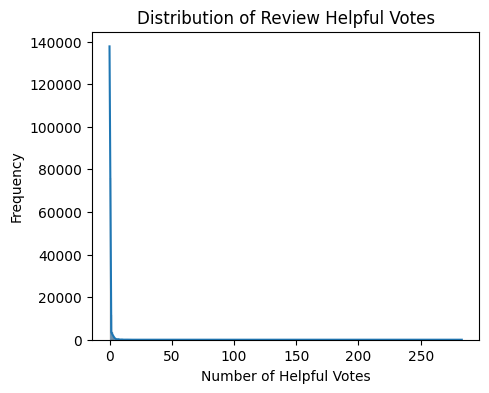

In [165]:
plt.figure(figsize=(5, 4)) #purely for limiting the impact on filesize
sns.histplot(reviews_eda,
             x='helpful_vote', binwidth=1, kde=True).set(title = 'Distribution of Review Helpful Votes')
plt.xlabel('Number of Helpful Votes')
plt.ylabel('Frequency')
plt.show()

Recall that over 80% of the reviews in our dataset were NOT helpful, and as a result the graph is illegible. Let's check some quantiles to get a sense of what interesting breakpoints might be.

In [166]:
(votes_ptile_0, votes_ptile_50, votes_ptile_60, votes_ptile_70, votes_ptile_80,
  votes_ptile_90, votes_ptile_95, votes_ptile_99,  votes_ptile_999) = reviews_eda.loc[reviews_eda['helpful_vote'] > 0, 'helpful_vote'].quantile([0, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999])
print(f'''Among non-zero votes, the 0th percentile is {votes_ptile_0}.
The 50th percentile is {votes_ptile_50}.
The 60th percentile is {votes_ptile_60}.
The 70th percentile is {votes_ptile_70}.
The 80th percentile is {votes_ptile_80}.
The 90th percentile is {votes_ptile_90}.
The 95th percentile is {votes_ptile_95}.
The 99th percentile is {votes_ptile_99}.
The 99.9th percentile is {votes_ptile_999}.''')

Among non-zero votes, the 0th percentile is 1.0.
The 50th percentile is 1.0.
The 60th percentile is 1.0.
The 70th percentile is 2.0.
The 80th percentile is 2.0.
The 90th percentile is 4.0.
The 95th percentile is 6.0.
The 99th percentile is 15.0.
The 99.9th percentile is 47.44800000000032.


Let's winsorize this information and try graphing it again, omitting the zeroes.

In [167]:
reviews_eda['helpful_vote_winsorized'] = np.where(reviews_eda['helpful_vote'] > votes_ptile_99,
                                              votes_ptile_99,
                                              reviews_eda['helpful_vote'])

Below contains 19.62% of reviews, with remainder at 0 votes


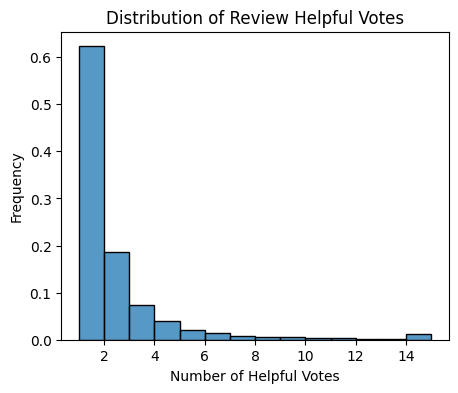

In [168]:
print(f'Below contains {len(reviews_eda.loc[reviews_eda["helpful_vote"] > 0]) / len(reviews_eda) * 100:.2f}% of reviews, with remainder at 0 votes')

plt.figure(figsize=(5, 4))  # purely for limiting the impact on filesize
sns.histplot(reviews_eda.loc[reviews_eda['helpful_vote'] > 0],
             x='helpful_vote_winsorized', binwidth=1, stat='density').set(title = 'Distribution of Review Helpful Votes')
plt.xlabel('Number of Helpful Votes')
plt.ylabel('Frequency')
plt.show()

So, even among reviews with helpful votes (which, according to the above, is about 19%), the distribution is extremely skewed, with over 60% of that proportion (or around 12,000 reviews) having only a single helpful vote.

We may want to consider **oversampling** as an option later on! For now, let's consider adding one more column to our dataframe: an arbitrarily bucketing of the number of helpful votes, which we will largely use for EDA rather than modelling.

It might also be interesting to get a sense if this varies by verification status.

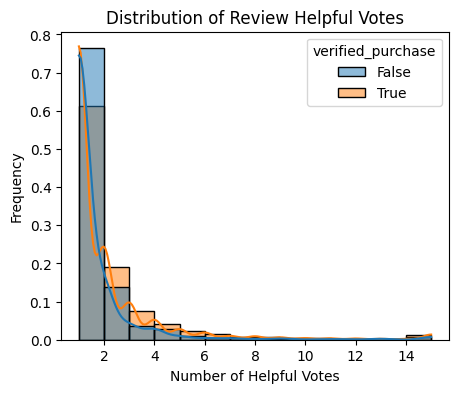

In [169]:
plt.figure(figsize=(5, 4))  # purely for limiting the impact on filesize
sns.histplot(reviews_eda.loc[reviews_eda['helpful_vote'] > 0],
             x='helpful_vote_winsorized', hue='verified_purchase', binwidth=1, stat='density', common_norm=False, kde=True).set(title = 'Distribution of Review Helpful Votes')
plt.xlabel('Number of Helpful Votes')
plt.ylabel('Frequency')
plt.show()

It doesn't really appear to meaningfully vary at all. Nor really, does rating.

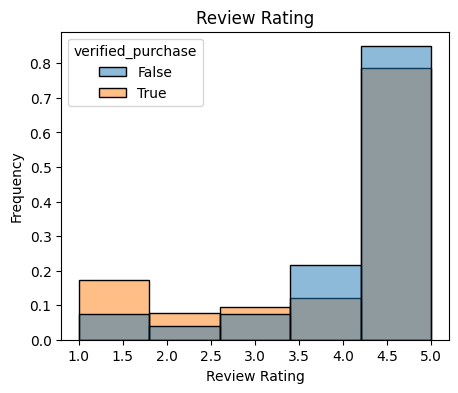

In [170]:
plt.figure(figsize=(5, 4)) #keeping filesize in mind

sns.histplot(reviews_eda,
             x='rating', hue='verified_purchase', bins = 5, stat="density", common_norm=False)
plt.title('Review Rating')
plt.xlabel('Review Rating')
plt.ylabel('Frequency')
plt.show()

Interestingly, a strong majority of reviews are verified purchases! So we should bear in mind that this is not balanced across our sample.

In [171]:
reviews_eda[['verified_purchase','text']].groupby(by='verified_purchase').count()

,text
verified_purchase,
False,13005
True,81550


### Review Content
Next let's consider the most important information for a review: the title,
text, and images that make up the content of the review.

First, let's consider the title, which is the bolded portion above the review that users often pick to briefly encapsulate their feelings about the product. Consider the following examples:

In [174]:
reviews_eda[['title']].head(5)

,title
0,Beautiful and excellent quality
1,Easy
2,Just adorable!!!
3,Wonderful Scent and Long-lasting
4,Makes an unpleasant sound when grinding


Just from looking at these, some are more helpful than others. "Beautiful and excellent quality" clearly indicates that the reviewer was impressed with both the aesthetics and function of the product. "Wonderful Scent and Long-Lasting" is (presumably) exactly what you'd like to know about the product in question. Equally "makes an unpleasant sound when grinding" is a clear sign that the reviewer is not happy, but "easy" doesn't give us a ton of specific information, and "just adorable" is not exactly hyper specific either: a grizzly bear playing with a watermelon is possibly adorable, but not something you'd want in your kitchen.

Let's hypothesize that the length of the review is good information to have when determining whether a review is helpful or not, and examine whether that's true. First, let's check the distribution.

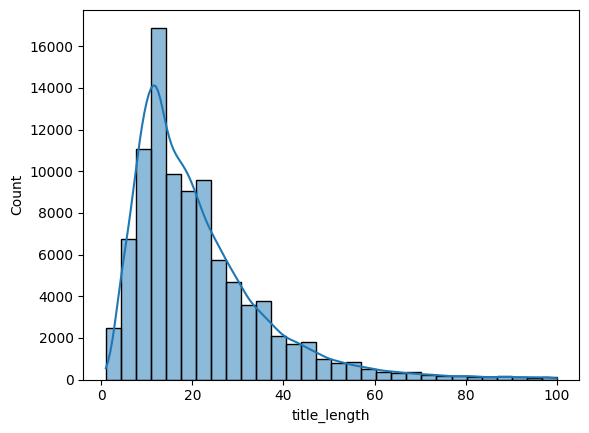

In [176]:
reviews_eda['title_length'] = reviews_eda['title'].str.strip().str.len() # remove leading and trailing spaces before

sns.histplot(reviews_eda['title_length'], bins=30, kde=True);

Conspicuously, when the leading and trailing whitespace is trimmed, the longest title is 100 chars. Possibly a max view. And while there probably isn't a real difference between 99 chars and 100, it's hard to imagine how a single character (or even four) can constitute a useful title.

Meanwhile, the modal length looks like it's 12 characters, which is exactly enough to say "that's short" or express a brief sentiment, but not enough to be really specific about the product experience.

In [177]:
# Twelve characters is not a lot!
len("that's short")

12

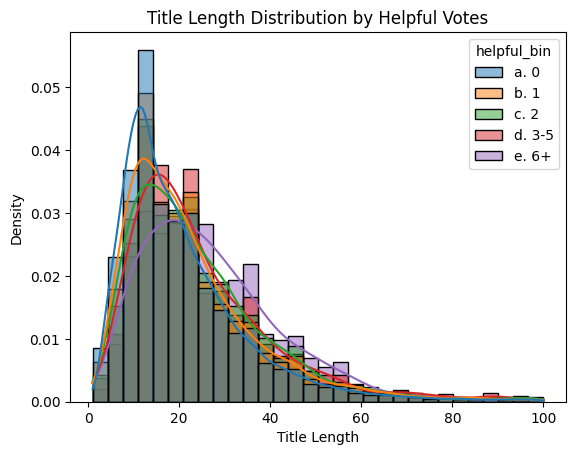

In [179]:
def_hue_order = [ 'a. 0', 'b. 1', 'c. 2', 'd. 3-5', 'e. 6+']

sns.histplot(reviews_eda, x='title_length', hue='helpful_bin', hue_order = def_hue_order,  bins=30, stat='density', common_norm=False, kde=True);
plt.title(f'Title Length Distribution by Helpful Votes')
plt.xlabel('Title Length')
plt.ylabel('Density')
plt.show()

Sure enough, while the effect is not enormous, the "more helpful" buckets are all right skewed, and the mode for each density is further from 0 than the previous one. So we can probably feel reasonably confident that the effect is real, and this information might be useful later.

> Add blockquote



### Review Text
Now let's consider the text. Let's start by taking the first 5 reviews in our dataframe and printing the first 500 chars of the reviews.

In [180]:
pd.options.display.max_colwidth = 500 #We need to change this back afterwards!
reviews[['text']].head(5)


,text
0,"I purchased these to add to my wreaths. These are excellent quality, the nicest eucalyptus I've purchased to date. I will send photo when my wreath is complete. They look real! I was so pleased with them that I ordered 2 more sets."
1,Work the best
2,Perfect!!!! Love it!
3,"It was packaged nicely, shipping time was super fast, I will certainly purchase again."
4,"The first couple of times I used this it worked fine. It's not quiet by any means, but I like the design and how I can remove the part that holds the spices for easy cleaning. Somewhere along the way it started making an awful sharp kind of grinding sound when in use (this is within the first couple weeks). It sounds broken, but it still works. Since it didn't make this sound at first I have to assume it's not supposed to make the sound. But it's pretty awful and now I avoid using it unles..."


Sure enough, the first and fifth reviews are long, and they use that char length by communicate specific nuances of the product. In the first case, we get a sense of what the reviewer was making the purchase for, why they were good, and what the outcome was. In the fifth review, which actually runs past 500 characters, we get an interesting narrative about their purchase experience. Meanwhile the shortest review is difficult to parse, and the fourth review (in row 3) mostly talks about the shipping time, and not how they actually found the purchase experience!

Mind you, the actual data does not seem to agree with this viewpoint...

In [181]:
reviews[['text','helpful_vote']].head(5)


,text,helpful_vote
0,"I purchased these to add to my wreaths. These are excellent quality, the nicest eucalyptus I've purchased to date. I will send photo when my wreath is complete. They look real! I was so pleased with them that I ordered 2 more sets.",0
1,Work the best,0
2,Perfect!!!! Love it!,0
3,"It was packaged nicely, shipping time was super fast, I will certainly purchase again.",1
4,"The first couple of times I used this it worked fine. It's not quiet by any means, but I like the design and how I can remove the part that holds the spices for easy cleaning. Somewhere along the way it started making an awful sharp kind of grinding sound when in use (this is within the first couple weeks). It sounds broken, but it still works. Since it didn't make this sound at first I have to assume it's not supposed to make the sound. But it's pretty awful and now I avoid using it unles...",0


In [182]:
##RUN THIS IF RUNNING THE ABOVE CELLS!!!!
pd.options.display.max_colwidth = 50

Nevertheless, from a human judgement standpoint, it is clear that the 12 characters in "work the best" do not capture as much information as the longer reviews. So we should look into whether or not that turns out to be the case for the overall data.



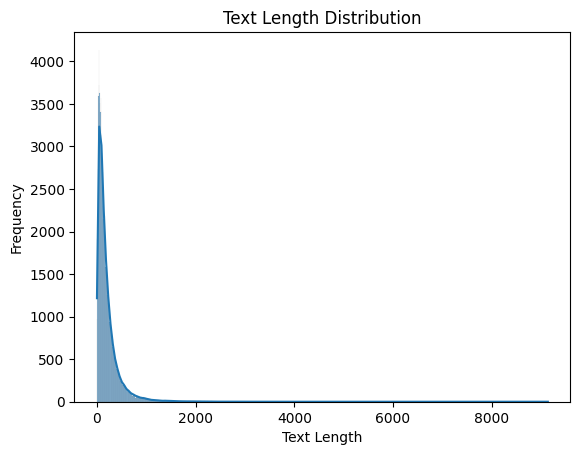

In [184]:
reviews_eda['text_length'] = reviews_eda['text'].str.strip().str.len() # remove leading and trailing spaces before

sns.histplot(reviews_eda['text_length'], kde=True);
plt.title(f'Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

There are an enormous number of outliers here, so let's consider winsorizing. Of course, there must be a point at which there are diminishing (or even negative) returns on increasing the review length, so we probably want to use some judgement in our cutoff point. As it happens, the 90th percentile is 430 chars, which seems like enough to capture a relatively interesting idea (and approximately the length of the text in this markup cell).

In [185]:
print(len('''There are an enormous number of outliers here, so let's consider winsorizing.
Of course, there must be a point at which there are diminishing (or even negative) returns on increasing the review length,
so we probably want to use some judgement in our cutoff point.
As it happens, the 90th percentile is 430 chars, which seems like enough to capture a relatively interesting idea
(and approximately the length of the text in this markup cell).'''))

442


In [186]:
# Max review length is extremely long!
max(reviews['text_length'])

9138

In [187]:
# Reviews DO periodically only contain whitespace, but it's rare.
len(reviews.loc[reviews['text_length'] == 0])

579

Winsorized at 442.


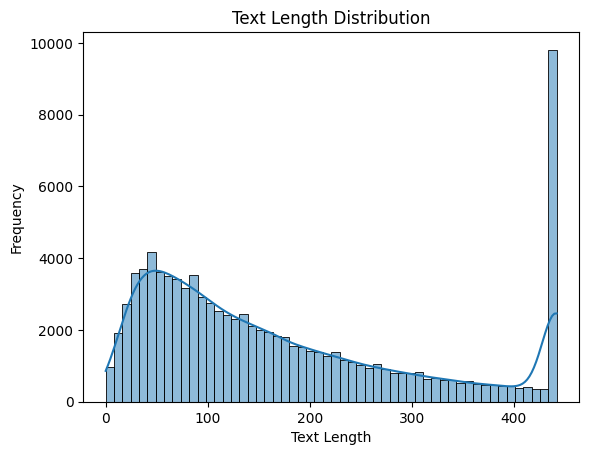

In [189]:
reviews_eda['text_length_winsorized'] = reviews_eda['text_length'].clip(upper=reviews_eda['text_length'].quantile(0.90))
print(f"Winsorized at {int(reviews['text_length_winsorized'].max())}.")

sns.histplot(reviews_eda['text_length_winsorized'], kde=True);
plt.title(f'Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

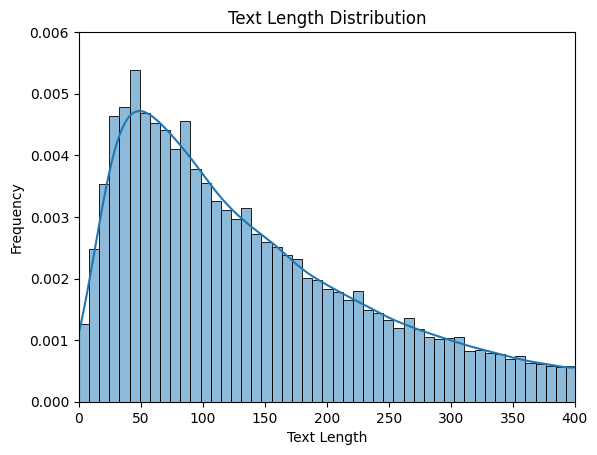

In [190]:
#Let's capture the greater mass of the distribution.

sns.histplot(reviews_eda['text_length_winsorized'], kde=True, stat='density');
plt.title(f'Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.xlim(0,400)
plt.ylim(0,0.006)
plt.show()

So the tail is extremely long, but most of the mass of the distribution is in short reviews. And how do these look when segmented by our arbitrary review helpfulness buckets? Well, as it happens, the distributions with more helpful votes are clearly shifted right. Despite being massively less frequent than other reviews overall, after a certain point in the distribution reviews with 6+ helpful votes are a plurality! Review quality and text length appear to be correlated.  

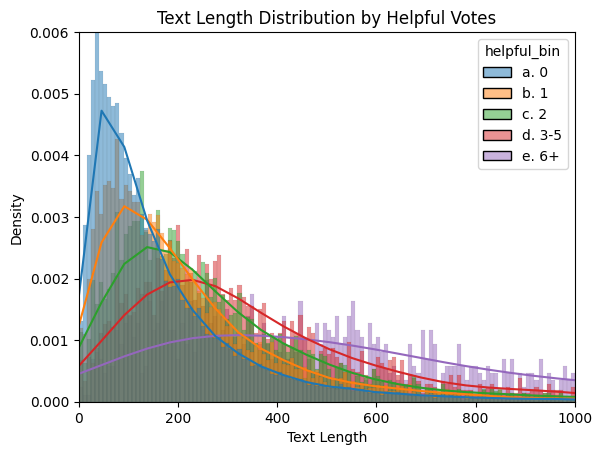

In [191]:
# winsorized value is no good for this - enormous point mass at 430.
sns.histplot(reviews, x='text_length', kde=True, stat='density', common_norm=False, hue='helpful_bin', hue_order = def_hue_order);
plt.title(f'Text Length Distribution by Helpful Votes')
plt.xlabel('Text Length')
plt.ylabel('Density')
plt.xlim(0,1000) #Otherwise the scale is invisible.
plt.ylim(0,0.006)
plt.show()

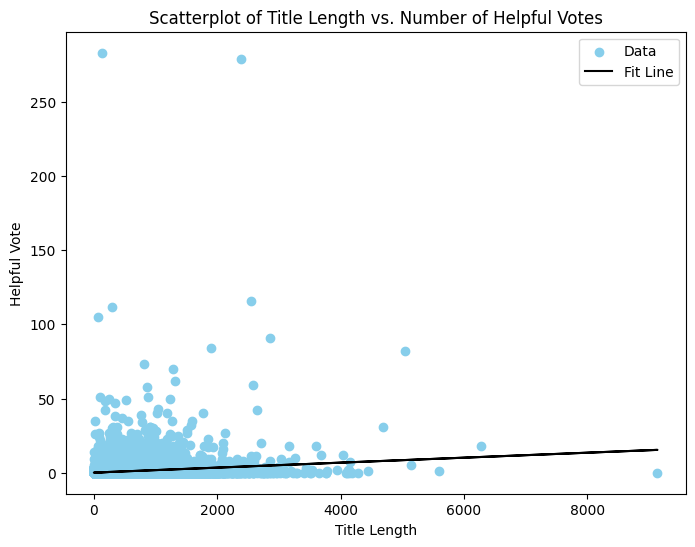

In [195]:
# Correlation is straightforward to validate, actually
review_length = reviews['text_length']
helpful_vote = reviews['helpful_vote']
slope, intercept, corr, p, sd = linregress(review_length, helpful_vote)

# Create scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(review_length, helpful_vote, color='skyblue', label='Data')

# Add best fit line
plt.plot(review_length, intercept + slope * review_length, color='black', label='Fit Line')

# Add labels and title
plt.title('Scatterplot of Title Length vs. Number of Helpful Votes')
plt.xlabel('Title Length')
plt.ylabel('Helpful Vote')
plt.legend()
# plt.ylim(0,30)
plt.show()

In [196]:
print(f"Correlation: {corr}\n p-value: {p}\n Standard Deviation: {sd}")

Correlation: 0.19327000146824272
 p-value: 0.0
 Standard Deviation: 2.7674681353605128e-05


Observe that the p-value is so small that capturing it causes a floating point truncation error, and the correlation is meaningfully non-zero. While it's not a silver bullet for determining helpfulness, it certainly seems like a good signal.

#### Blank Reviews
Let's briefly consider blank reviews.

In [197]:
reviews['is_blank_review'] = reviews['text_length'] == 0
reviews['is_blank_review'].value_counts(normalize=True)

<ipython-input-197-c0b1d607278e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['is_blank_review'] = reviews['text_length'] == 0


is_blank_review
False    0.993877
True     0.006123
Name: proportion, dtype: float64

In [198]:
pd.pivot_table(data=reviews[['is_blank_review','is_helpful','rating']], values='is_helpful', index='is_blank_review', columns='rating', aggfunc=['mean','count'])

mean                                          count  \
rating                  1         2         3         4         5      1   
is_blank_review                                                            
False            0.224757  0.160262  0.195387  0.268356  0.181323  12013   
True             0.226667  0.157895  0.038462  0.205882  0.247059     75   

                                           
rating              2     3      4      5  
is_blank_review                            
False            5335  6981  10024  59623  
True               19    26     34    425

As it turns out, blanks reviews seem to be helpful almost as often as non-blank reviews! Though in middle of the road reviews (where nuance is presumably most helpful) the difference is low enough that it is actually significant, despite the sample size.

In [199]:
pd.pivot_table(data=reviews[['is_blank_review','title_length','rating']], values='title_length', index='is_blank_review', columns='rating', aggfunc='mean')

rating,1,2,3,4,5
is_blank_review,,,,,
False,23.75052,23.481537,23.279903,23.181664,19.996897
True,49.00000,47.789474,51.230769,34.205882,26.035294


In [200]:
ttest_ind(reviews.loc[(reviews['is_blank_review'] == True) & (reviews['rating'] == 3)]['is_helpful'],
          reviews.loc[(reviews['is_blank_review'] == False) & (reviews['rating'] == 3)]['is_helpful'])

TtestResult(statistic=-2.0169145791685956, pvalue=0.04374250690435803, df=7005.0)

Overall, this seems interesting, but too narrow to be an important modelling feature.

### Images

Let's consider images. One logical hypothesis is that having an image is helpful. Indeed, that appears to be the case.

In [201]:
reviews_eda.columns

Index(['rating', 'title', 'text', 'asin', 'helpful_vote', 'verified_purchase',
       'date', 'dow', 'month', 'is_helpful', 'title_length', 'text_length',
       'is_blank_review', 'reviews_per_user', 'has_variant_reviews',
       'num_images', 'helpful_vote_winsorized', 'helpful_bin',
       'text_length_winsorized'],
      dtype='object')

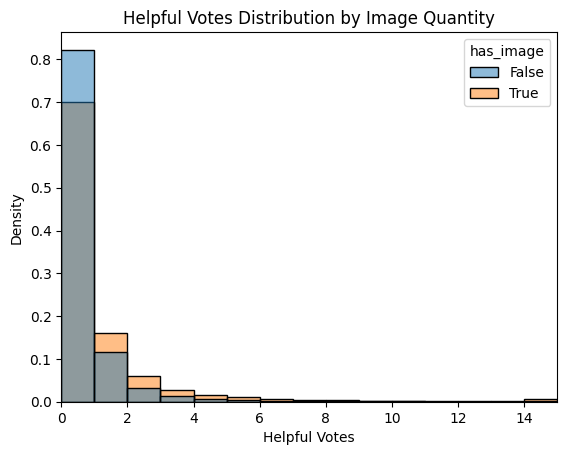

In [228]:
reviews_eda['has_image'] = reviews_eda['num_images'] > 0
sns.histplot(reviews_eda, x='helpful_vote_winsorized', stat="density", common_norm = False, binwidth=1, hue='has_image');
plt.title(f'Helpful Votes Distribution by Image Quantity')
plt.xlabel('Helpful Votes')
plt.ylabel('Density')
plt.xlim(0,15)
plt.show()

In [229]:
pd.pivot_table(data=reviews_eda[['has_image','is_helpful','rating']], values='is_helpful', index='has_image', columns='rating', aggfunc=['mean','count'])

mean                                          count        \
rating            1         2         3         4         5      1     2   
has_image                                                                  
False      0.210839  0.142301  0.183828  0.255491  0.160294  10259  4624   
True       0.302898  0.273973  0.265048  0.333333  0.298926   1829   730   

                              
rating        3     4      5  
has_image                     
False      6060  8423  50738  
True        947  1635   9310

It definitely seems like the answer is yes: image contributes toward general review helpfulness. And why not - marketing images can be misleading, but candid photographs attached to a review can give a real impression of how it appears in real life.

### Date
Finally, lets consider date. Does the day of the week have any bearing on review helpfulness?

In [231]:
pd.pivot_table(data=reviews_eda[['dow','is_helpful']], values='is_helpful', index='dow', aggfunc=['mean','count'])

,mean,count
,is_helpful,is_helpful
dow,,
0,0.193717,14547
1,0.194199,14274
2,0.194306,14050
3,0.197806,13493
4,0.197521,12748
5,0.195196,12449
6,0.201324,12994


Seemingly not! What about the month?

In [232]:
pd.pivot_table(data=reviews_eda[['month','is_helpful']], values='is_helpful', index='month', aggfunc=['mean','count'])

,mean,count
,is_helpful,is_helpful
month,,
1,0.236649,25316
2,0.217551,19099
3,0.172300,21538
4,0.156516,11986
5,0.181592,6421
6,0.184878,4219
7,0.170207,3437
8,0.115481,2390


Here, we DO have an effect. But there is an obvious reason why that might be the case. In order to be helpful, a review must be seen by a user, and then voted as helpful. Logically the longer a review stays visible, the more opportunities it has for this to happen. So clearly we should not interpret this as a sign that Fall reviews are bad, but rather than longevity is an important factor in the likelihood that reviews are helpful (and as such, it's ideal that we restricted ourselves to recent records!).

# Modeling: Introduction

We will be implementing **model stacking** where the output of text processing models will be used as input for our classifier models.

As we build up towards the resolution in predicting if review is helpful, we will apply the following Machine Learning tools:
- Topic Modeling, using GENSIM's [Latent Dirichlet Allocation](https://radimrehurek.com/gensim/models/ldamulticore.html) (LDA)
- Sentiment Analysis, using [TextBlob's sentiment.polarity](https://textblob.readthedocs.io/en/dev/quickstart.html)
- Logistic Regression
  - scikit-learn's [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
  - Gradient Boosting (a gradient-boosted decision tree) via [XGBoost](https://xgboost.readthedocs.io/en/stable/)

*This is in addition to applying [langdetect](https://pypi.org/project/langdetect/) to determine if a review was in English during Data Preprocessing.*

In [233]:
# base data

df = reviews.copy()

# Topic Modeling

As stated above, we will apply Topic Modeling using GENSIM's [Latent Dirichlet Allocation](https://radimrehurek.com/gensim/models/ldamulticore.html) (LDA). Topic Modeling will output clusters of similar word groups, and by doing so, we can examine consistent "topics" across reviews and use them as a gauge for classes. For each cluster identied, the LDA model will output the probabily this review belongs to the given topic (which we will use as a feature in our classifiers).

First, let's clean the text fields of any characters which will not be useful for our purposes.

In [234]:
# expect  a dataframe called df with multiple fields including df['text'] for this section.
# for output, update df to drop text column and add topical (numerical) ones intead.

def clean_text(text):
    # Remove HTML tags

    text = str(text)

    text = re.sub(r'<[^>]+>', '', text)
    # Remove punctuation and special characters, and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize the text into words
    tokens = word_tokenize(text)
    # Lowercase the words
    tokens = [word.lower() for word in tokens]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens


reviews_txt = df['text']

processed_reviews = [clean_text(review) for review in reviews_txt]

# Create a dictionary representation of the reviews
dictionary = corpora.Dictionary(processed_reviews)

# Filter out words that appear in less than 20 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=50, no_above=0.7)

# Convert the reviews to a bag-of-words representation
bow_corpus = [dictionary.doc2bow(review) for review in processed_reviews]

# Train the LDA (Latent Dirichlet Allocation) model
lda_model = models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=10,workers=24)

# Print the topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))



Topic: 0 
Words: 0.014*"product" + 0.014*"one" + 0.010*"good" + 0.008*"back" + 0.008*"time" + 0.007*"chair" + 0.007*"would" + 0.007*"great" + 0.007*"quality" + 0.007*"buy"
Topic: 1 
Words: 0.016*"great" + 0.014*"well" + 0.012*"like" + 0.010*"easy" + 0.010*"nice" + 0.009*"hold" + 0.009*"use" + 0.008*"fit" + 0.008*"look" + 0.008*"work"
Topic: 2 
Words: 0.019*"easy" + 0.018*"use" + 0.014*"one" + 0.014*"great" + 0.013*"work" + 0.012*"love" + 0.010*"clean" + 0.009*"get" + 0.008*"make" + 0.007*"would"
Topic: 3 
Words: 0.021*"love" + 0.016*"look" + 0.013*"color" + 0.013*"like" + 0.011*"nice" + 0.011*"good" + 0.011*"great" + 0.010*"one" + 0.010*"quality" + 0.009*"would"
Topic: 4 
Words: 0.010*"like" + 0.010*"pillow" + 0.010*"time" + 0.009*"great" + 0.009*"one" + 0.008*"coffee" + 0.007*"well" + 0.007*"good" + 0.007*"get" + 0.006*"use"


The breadth of the data makes the exercise challenging in this case! The probabilities are reasonable low, and it's challenging to identify a consistent trend.

Let's focus on extremely helpful reviews:

In [248]:
# topic modeling for helpful reviews
helpful_mask = df['helpful_vote'] >=10
helpful_reviews = reviews_txt[helpful_mask]

processed_reviews = [clean_text(review) for review in helpful_reviews]

# Create a dictionary representation of the reviews
dictionary = corpora.Dictionary(processed_reviews)

# Filter out words that appear in less than 20 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=50, no_above=0.7)

# Convert the reviews to a bag-of-words representation
bow_corpus = [dictionary.doc2bow(review) for review in processed_reviews]

# Train the LDA (Latent Dirichlet Allocation) model
lda_model = models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=10,workers=24)

# Print the topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.071*"im" + 0.058*"would" + 0.055*"look" + 0.055*"like" + 0.037*"fit" + 0.037*"buy" + 0.036*"easy" + 0.034*"keep" + 0.033*"love" + 0.032*"really"
Topic: 1 
Words: 0.060*"bed" + 0.059*"like" + 0.049*"time" + 0.040*"dont" + 0.037*"get" + 0.036*"need" + 0.033*"one" + 0.032*"im" + 0.028*"want" + 0.027*"also"
Topic: 2 
Words: 0.070*"use" + 0.054*"clean" + 0.054*"love" + 0.050*"easy" + 0.036*"come" + 0.035*"great" + 0.031*"work" + 0.028*"much" + 0.028*"get" + 0.027*"like"
Topic: 3 
Words: 0.107*"one" + 0.053*"time" + 0.041*"get" + 0.040*"first" + 0.036*"used" + 0.035*"back" + 0.034*"much" + 0.028*"like" + 0.027*"way" + 0.026*"bought"
Topic: 4 
Words: 0.073*"product" + 0.055*"one" + 0.044*"would" + 0.043*"made" + 0.041*"year" + 0.038*"also" + 0.037*"well" + 0.036*"great" + 0.033*"purchase" + 0.031*"make"


Here it actually seems to work a little better, and we have some meaningful probabilities, but it's difficult to intuitively assessment what they mean. For example, the tokens "one time" appear consistently in topic 3. Perhaps they refer to an anecdote, or even a multi-use product that wound up only working the first time.

Next, lets consider "bad" reviews (i.e. reviews that did not like the product, rather than reviews that are of low quality).

In [247]:
# topic modeling for 1 star reviews
low_rating_mask = df['rating'] <2

low_reviews = reviews_txt[low_rating_mask]

processed_reviews = [clean_text(review) for review in low_reviews]

# Create a dictionary representation of the reviews
dictionary = corpora.Dictionary(processed_reviews)

# Filter out words that appear in less than 20 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=50, no_above=0.7)

# Convert the reviews to a bag-of-words representation
bow_corpus = [dictionary.doc2bow(review) for review in processed_reviews]

# Train the LDA (Latent Dirichlet Allocation) model
lda_model = models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=10,workers=24)

# Print the topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.021*"like" + 0.017*"look" + 0.013*"one" + 0.012*"cheap" + 0.012*"quality" + 0.012*"time" + 0.011*"doesnt" + 0.011*"even" + 0.010*"picture" + 0.010*"would"
Topic: 1 
Words: 0.024*"work" + 0.015*"product" + 0.013*"time" + 0.012*"would" + 0.011*"one" + 0.011*"month" + 0.010*"get" + 0.009*"return" + 0.009*"doesnt" + 0.009*"make"
Topic: 2 
Words: 0.024*"use" + 0.021*"one" + 0.020*"time" + 0.015*"broke" + 0.015*"month" + 0.013*"money" + 0.011*"used" + 0.011*"lid" + 0.011*"first" + 0.010*"dont"
Topic: 3 
Words: 0.017*"product" + 0.016*"piece" + 0.014*"one" + 0.013*"box" + 0.013*"item" + 0.012*"broken" + 0.012*"like" + 0.010*"get" + 0.010*"put" + 0.010*"together"
Topic: 4 
Words: 0.021*"dont" + 0.020*"money" + 0.019*"one" + 0.019*"back" + 0.015*"like" + 0.013*"waste" + 0.013*"would" + 0.012*"pillow" + 0.010*"buy" + 0.009*"bed"


Here we also struggle to identify a consistent trend.  Topic 4 seems to be associated with sleep, or the bedroom, but the probabilities are not hugely inspiring.

We can repeat the exercise for reviews that were enthusiastic about the product.

In [237]:
# topic modeling for 5 star reviews
high_rating_mask = df['rating'] ==5

high_reviews = reviews_txt[high_rating_mask]

processed_reviews = [clean_text(review) for review in high_reviews]

# Create a dictionary representation of the reviews
dictionary = corpora.Dictionary(processed_reviews)

# Filter out words that appear in less than 20 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=50, no_above=0.7)

# Convert the reviews to a bag-of-words representation
bow_corpus = [dictionary.doc2bow(review) for review in processed_reviews]

# Train the LDA (Latent Dirichlet Allocation) model
lda_model = models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=10,workers=24)

# Print the topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.026*"great" + 0.015*"work" + 0.014*"like" + 0.013*"pillow" + 0.012*"love" + 0.011*"one" + 0.010*"easy" + 0.010*"chair" + 0.010*"use" + 0.009*"comfortable"
Topic: 1 
Words: 0.018*"well" + 0.013*"fit" + 0.013*"soft" + 0.013*"one" + 0.011*"color" + 0.011*"great" + 0.010*"love" + 0.008*"perfectly" + 0.008*"made" + 0.007*"hold"
Topic: 2 
Words: 0.031*"easy" + 0.022*"look" + 0.019*"great" + 0.018*"love" + 0.012*"would" + 0.012*"recommend" + 0.011*"nice" + 0.011*"sturdy" + 0.010*"put" + 0.010*"perfect"
Topic: 3 
Words: 0.037*"love" + 0.025*"perfect" + 0.023*"great" + 0.019*"good" + 0.018*"product" + 0.017*"quality" + 0.013*"size" + 0.012*"gift" + 0.011*"work" + 0.010*"bought"
Topic: 4 
Words: 0.014*"one" + 0.013*"use" + 0.011*"like" + 0.010*"easy" + 0.009*"make" + 0.008*"great" + 0.008*"well" + 0.008*"get" + 0.008*"water" + 0.008*"really"


Again, difficult to observe a consistent trend.

Let's review a total summary of the review texts.

In [238]:
# Final Topic Modeling

clean_reviews = df['text'].apply(clean_text)

# Create dictionary and corpus needed for Topic Modeling
dictionary = corpora.Dictionary(clean_reviews)
dictionary.filter_extremes(no_below=20, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in clean_reviews]

# LDA Model
lda_model = models.LdaMulticore(corpus, num_topics=5, id2word=dictionary, passes=10, workers=4)

# Getting the document-topic distribution for each document
topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]

# Convert the topic distributions to a more usable format like a DataFrame
topic_probs = []

for dist in topic_distributions:
    doc_probs = {f'topic_{i}': 0.0 for i in range(lda_model.num_topics)}
    for topic_num, prob in dist:
        doc_probs[f'topic_{topic_num}'] = prob
    topic_probs.append(doc_probs)

topic_df = pd.DataFrame(topic_probs)

In [239]:
topic_df.describe()

,topic_0,topic_1,topic_2,topic_3,topic_4
count,94555.000000,94555.000000,94555.000000,94555.000000,94555.000000
mean,0.258037,0.195905,0.166215,0.178967,0.196336
std,0.290767,0.281926,0.253100,0.253472,0.261447
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.016783,0.014433,0.014555,0.015755,0.017157
50%,0.120953,0.034457,0.033699,0.040180,0.041267
75%,0.460543,0.300500,0.216430,0.271817,0.323369
max,0.983935,0.992753,0.994501,0.993513,0.991286


In [240]:
topic_df.dtypes

topic_0    float64
topic_1    float64
topic_2    float64
topic_3    float64
topic_4    float64
dtype: object

In [241]:
# output length of topic_df
len(topic_df)

94555

In [242]:
# output length of df before changing it
len(df)

94555

In [243]:
# Merge topic modeling results back to the main dataframe (confirming sizes are the same first)
if len(df) == len(topic_df):
    df = pd.concat([df, topic_df], axis=1)
    # Fill NaN values in topic columns with 0
    df[[f'topic_{i}' for i in range(5)]] = df[[f'topic_{i}' for i in range(5)]].fillna(0.0)
else:
    raise Exception('Error in Topic Modeling')

In [244]:
df.isnull().sum()

rating                     5166
title                      5166
text                       5166
asin                       5166
helpful_vote               5166
verified_purchase          5166
date                       5166
dow                        5166
month                      5166
is_helpful                 5166
title_length               5166
text_length                5166
is_blank_review            5166
reviews_per_user           5166
has_variant_reviews        5166
num_images                 5166
helpful_vote_winsorized    5166
helpful_bin                5166
text_length_winsorized     5166
topic_0                       0
topic_1                       0
topic_2                       0
topic_3                       0
topic_4                       0
dtype: int64

In [245]:
# Topic Modeling introduced extra rows where only topic_x fields are not null

nulls_in_df = df.isnull().any().any()

if nulls_in_df:
    print('Rows before dropping nulls: ', len(df))
    df.dropna(inplace=True)
    print('Rows after dropping nulls: ', len(df))

Rows before dropping nulls:  99721
Rows after dropping nulls:  94555


In [246]:
# raise Exception("End of Topic Modeling")


Overall, despite some fairly sophisticated techniques, the breadth of amazon reviews (in terms of both tone, quality, and product space) seems to defeat the effort to do topic modelling. A key learning: the sheer scope of the data can overwhelm bag-of-word techniques!

As a next step, we could focus on specific product SKUs, or narrow our data further and accept some loss in scope.

# Feature Engineering


In this section, we will update values in preparation for modeling
- turning booleans to integers
- turn categorical data into a numerical one
- generate additional features of interest
- add sentiment analysis
- train-test split

In addition, we will run a correlation matrix top get a glimpse of features correlated with the target.

In [249]:
# save df copy (if needed)
df_copy = df.copy()

In [250]:
# Reset opportunity
# df = df_copy

In [251]:
# output here: df = a model ready dataframe from reviews, EXCEPT it has text (as is) as it will be processed in topic modeling section

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94555 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   rating                   94555 non-null  float64       
 1   title                    94555 non-null  object        
 2   text                     94555 non-null  object        
 3   asin                     94555 non-null  object        
 4   helpful_vote             94555 non-null  float64       
 5   verified_purchase        94555 non-null  object        
 6   date                     94555 non-null  datetime64[ns]
 7   dow                      94555 non-null  float64       
 8   month                    94555 non-null  float64       
 9   is_helpful               94555 non-null  object        
 10  title_length             94555 non-null  float64       
 11  text_length              94555 non-null  float64       
 12  is_blank_review          94555 non-nu

In [ ]:
# change boolean to 0,1
bool_cols = ['verified_purchase', 'is_helpful', 'has_variant_reviews', 'is_blank_review']
df[bool_cols] = df[bool_cols].astype(int)
df.dtypes


rating                 float64
title                   object
text                    object
asin                    object
helpful_vote           float64
verified_purchase        int64
dow                    float64
month                  float64
is_helpful               int64
title_length           float64
text_length            float64
is_blank_review          int64
reviews_per_user       float64
has_variant_reviews      int64
num_images             float64
topic_0                float64
topic_1                float64
topic_2                float64
topic_3                float64
topic_4                float64
dtype: object

Month is expressed as a number but it really is categorical data as the numbers dont have numerical value. One way to address this is by using **One-Hot Encoding** on this field.

The same applies to days of the week (`dow`). One One-Hot Encoding is done, we can drop th original columns

In [ ]:
month_ohe = pd.get_dummies(df['month'], prefix='month', dtype=int).astype(int)
month_ohe.head(2)

,month_1.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0
0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0


In [ ]:
df = pd.concat([df, month_ohe], axis=1)
df.dtypes

rating                 float64
title                   object
text                    object
asin                    object
helpful_vote           float64
verified_purchase        int64
dow                    float64
month                  float64
is_helpful               int64
title_length           float64
text_length            float64
is_blank_review          int64
reviews_per_user       float64
has_variant_reviews      int64
num_images             float64
topic_0                float64
topic_1                float64
topic_2                float64
topic_3                float64
topic_4                float64
month_1.0                int64
month_2.0                int64
month_3.0                int64
month_4.0                int64
month_5.0                int64
month_6.0                int64
month_7.0                int64
month_8.0                int64
month_9.0                int64
dtype: object

In [ ]:
dow_ohe = pd.get_dummies(df['dow'], prefix='dow', dtype=int).astype(int)
dow_ohe.head(2)

,dow_0.0,dow_1.0,dow_2.0,dow_3.0,dow_4.0,dow_5.0,dow_6.0
0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1


In [ ]:
df = pd.concat([df, dow_ohe], axis=1)
df.dtypes

rating                 float64
title                   object
text                    object
asin                    object
helpful_vote           float64
verified_purchase        int64
dow                    float64
month                  float64
is_helpful               int64
title_length           float64
text_length            float64
is_blank_review          int64
reviews_per_user       float64
has_variant_reviews      int64
num_images             float64
topic_0                float64
topic_1                float64
topic_2                float64
topic_3                float64
topic_4                float64
month_1.0                int64
month_2.0                int64
month_3.0                int64
month_4.0                int64
month_5.0                int64
month_6.0                int64
month_7.0                int64
month_8.0                int64
month_9.0                int64
dow_0.0                  int64
dow_1.0                  int64
dow_2.0                  int64
dow_3.0 

In [ ]:
# drop month and dow
len(df.columns)

36

In [ ]:
df.drop(columns=['month', 'dow'], inplace=True)
len(df.columns)

34

In the future, the feature `helpful_vote` with the number of helpful vote must be removed as it would lead to **data leakage** against the target `is_helpful`

In [ ]:
df.dtypes

rating                 float64
title                   object
text                    object
asin                    object
helpful_vote           float64
verified_purchase        int64
is_helpful               int64
title_length           float64
text_length            float64
is_blank_review          int64
reviews_per_user       float64
has_variant_reviews      int64
num_images             float64
topic_0                float64
topic_1                float64
topic_2                float64
topic_3                float64
topic_4                float64
month_1.0                int64
month_2.0                int64
month_3.0                int64
month_4.0                int64
month_5.0                int64
month_6.0                int64
month_7.0                int64
month_8.0                int64
month_9.0                int64
dow_0.0                  int64
dow_1.0                  int64
dow_2.0                  int64
dow_3.0                  int64
dow_4.0                  int64
dow_5.0 

In [ ]:
df.columns

Index(['rating', 'title', 'text', 'asin', 'helpful_vote', 'verified_purchase',
       'is_helpful', 'title_length', 'text_length', 'is_blank_review',
       'reviews_per_user', 'has_variant_reviews', 'num_images', 'topic_0',
       'topic_1', 'topic_2', 'topic_3', 'topic_4', 'month_1.0', 'month_2.0',
       'month_3.0', 'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0',
       'month_8.0', 'month_9.0', 'dow_0.0', 'dow_1.0', 'dow_2.0', 'dow_3.0',
       'dow_4.0', 'dow_5.0', 'dow_6.0'],
      dtype='object')

### Additional Features

Below are some additional features that could be helpful in determining if a review is helpful. We will use scikit-learn's [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) to encode and return labels related to classification data.

In [ ]:
df['product_category'] = df['asin'].apply(lambda x: x[:3])
df['brand'] = df['asin'].apply(lambda x: x[-3:])
df['exclamations'] = df['text'].apply(lambda x: x.count('!'))
df['capital_letters'] = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()))

label_encoder = LabelEncoder()
df['product_category'] = label_encoder.fit_transform(df['product_category'])
df['brand'] = label_encoder.fit_transform(df['brand'])

In [ ]:
# drop unused field moving forward
print('Cols Pre Drop: ', len(df.columns))
df.drop(columns=['asin'], inplace=True)
print('Cols Post Drop: ', len(df.columns))

Cols Pre Drop:  38
Cols Post Drop:  37


### Sentiment Analysis

Lastly, we suspect extreme views will be found more helpful. Hence, we will apply **sentiment analysis** and particularly **polarity** via the [TextBlob](https://textblob.readthedocs.io/en/dev/quickstart.html) library and in particular its's sentiment property (`sentiment.polarity`). The polarity will be a float in the range -1.0 to 1.0.

We will leverage the same `clean_text` function from Token Modeling but not it returns tokens.

In [ ]:
# TextBlob Sentiment
# df['sentiment_polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['sentiment_polarity'] = df['text'].apply(clean_text).str.join(' ')
df['sentiment_polarity'] = df['sentiment_polarity'].apply(lambda x: TextBlob(x).sentiment.polarity)


In [ ]:
df['sentiment_polarity'].head(2)

0    0.188447
1    0.662500
Name: sentiment_polarity, dtype: float64

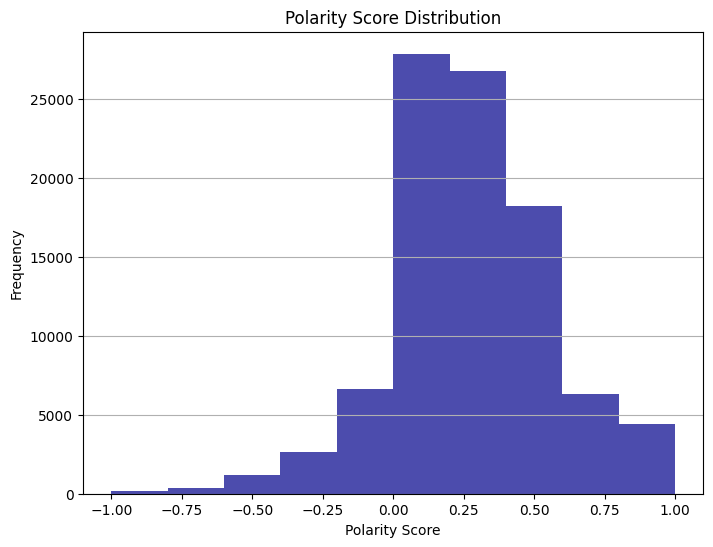

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df['sentiment_polarity'], bins=10, color='#00008B', alpha=0.7)
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.title('Polarity Score Distribution')

plt.grid(axis='y');

In [ ]:
# drop unused field moving forward
print('Cols Pre Drop: ', len(df.columns))
df.drop(columns=['title'], inplace=True)
print('Cols Post Drop: ', len(df.columns))

Cols Pre Drop:  38
Cols Post Drop:  37


From sentiment analysis, we can see reviews were determined likely be **neutral to positive**. Surprisigly, there isn't a negative peak on the negative side as expected.

### Correlation Matrix

Now that all values are numeric (except `text`), let's output a correlation matrix for the target.

We will first start by dropping `df['helpful_vote']` as that will likely lead to **data leakage**.


In [ ]:
# drop redundant (leaky)
del df['helpful_vote']

In [ ]:
df.dtypes

rating                 float64
text                    object
verified_purchase        int64
is_helpful               int64
title_length           float64
text_length            float64
is_blank_review          int64
reviews_per_user       float64
has_variant_reviews      int64
num_images             float64
topic_0                float64
topic_1                float64
topic_2                float64
topic_3                float64
topic_4                float64
month_1.0                int64
month_2.0                int64
month_3.0                int64
month_4.0                int64
month_5.0                int64
month_6.0                int64
month_7.0                int64
month_8.0                int64
month_9.0                int64
dow_0.0                  int64
dow_1.0                  int64
dow_2.0                  int64
dow_3.0                  int64
dow_4.0                  int64
dow_5.0                  int64
dow_6.0                  int64
product_category         int64
brand   

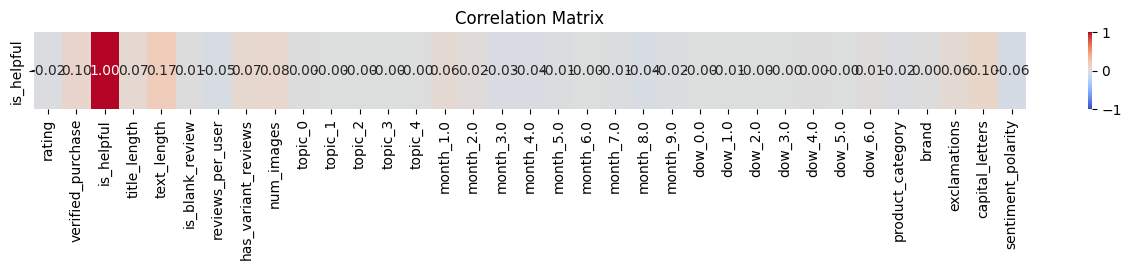

''

In [ ]:
# output correlation matrix

corr = df.drop('text', axis=1).corr() # exclude 'text'
corr_row = corr.loc[['is_helpful']]

plt.figure(figsize=(16, 1))
sns.heatmap(corr_row, vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()
;

By using a correlation matrix, no feature seens to have a  strong correlation with the target.

### Test-Train Split and Handling Imbalance

Now, we must address our **imbalance issue** identified early on (shown below). We will proceed by **upsampling** the minority class. Any subtler imbalanced will also be addressed via the `class_weight` parameters in the Regression section below.

We will also apply scikit-learn's [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to normalize our features in preparation for Machine Learning.


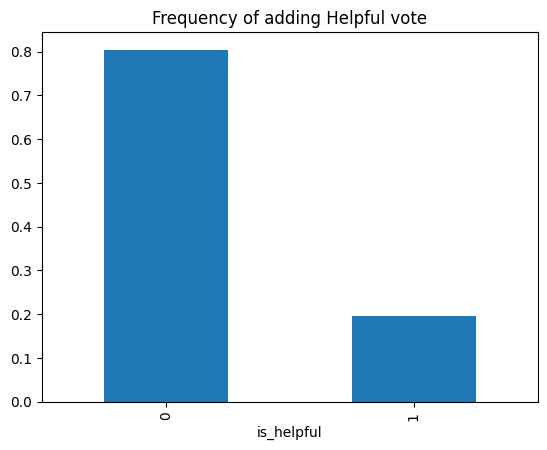

In [ ]:
df['is_helpful'].value_counts(normalize=True).plot.bar().set_title('Frequency of adding Helpful vote');

In [ ]:
# Feature set preparation - features  drop target and text

X = df.drop(['is_helpful', 'text'], axis=1)
y = df['is_helpful']

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=5450)

In [ ]:
# version with Text - features only drop target. Adding txt suffix. In this version, features are not scaled

X_txt = df.drop('is_helpful', axis=1)

X_resampled_txt, y_resampled_txt = ros.fit_resample(X_txt, y)

X_train_txt, X_test_txt, y_train_txt, y_test_txt = train_test_split(X_resampled_txt, y_resampled_txt, test_size=0.2, random_state=5450) # expect same as above due to seed

We have reached the end of this section as our main dataframe is ready for modeling, outside text processing which will be done in the next sections.

At this point, we've extracted some possible features.

In [ ]:
# save df copy (if needed)
df_copy2 = df.copy()

In [ ]:
# raise Exception("End of Feature Engineering Section")

# Logistic Regression Modeling

Below, we will try a sequence of classifiers to form a perspective on which might be a better approach in the challenge on predicting if a review will be voted as helpful at least once

For **hyperparameter tuning**, we will leverage scikit-learn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) which uses a cross-validated grid-search over a parameter grid based on user input. The inputted parameters to consider will be in the `parameters` map for each model while `.best_params_` property of each model will return the best parameters from the selection.

## Model Training


In [ ]:
# EVALUATION FUNCTION

def evaluate_model(model_name, model, train_features, train_target, test_features, test_target):
    eval_stats = {}

    fig, ax = plt.subplots()

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        eval_stats[type] = {}

        pred_proba = model.predict_proba(features)[:, 1]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # ROC
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'ROC Curve: ' + model_name)

        pred_target = model.predict(features)
        accuracy = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['Accuracy'] = accuracy

    df_eval_stats = pd.DataFrame(eval_stats).round(2)
    df_eval_stats = df_eval_stats.reindex(index=('ROC AUC', 'Accuracy'))

    print(df_eval_stats)
    print()

    print('Confusion Matrix:')
    print(confusion_matrix(test_target, model.predict(test_features)))

    print('Classification Report:')
    print(classification_report(test_target, model.predict(test_features)))

    return model_name, round(roc_auc, 2), round(accuracy, 2)

### Dummy Classiffier

We start with a dummy classifier (scikit-learn's [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)) as a sanity check, expecting every model should do better. With `strategy` as `most_frequent`, this classifier is just retuning the most frequent value across all. In other words, it will likely always "predict" the target is negative, as it's the majority class.

In [ ]:
%%time

dummy = DummyClassifier(random_state = 5450)

#paremeters for GridSearch
parameters = {'strategy': ('most_frequent', 'stratified', 'uniform', 'prior')}
dummy = GridSearchCV(estimator=dummy, param_grid=parameters, scoring='roc_auc')

dummy.fit(X_train, y_train)

CPU times: user 226 ms, sys: 34.2 ms, total: 260 ms
Wall time: 271 ms


GridSearchCV(estimator=DummyClassifier(random_state=5450),
             param_grid={'strategy': ('most_frequent', 'stratified', 'uniform',
                                      'prior')},
             scoring='roc_auc')

In [ ]:
#best params
dummy.best_params_

{'strategy': 'most_frequent'}

          train  test
ROC AUC     0.5   0.5
Accuracy    0.5   0.5

Confusion Matrix:
[[15105     0]
 [15285     0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.66     15105
           1       0.00      0.00      0.00     15285

    accuracy                           0.50     30390
   macro avg       0.25      0.50      0.33     30390
weighted avg       0.25      0.50      0.33     30390



/Users/rachelleperez/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rachelleperez/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rachelleperez/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

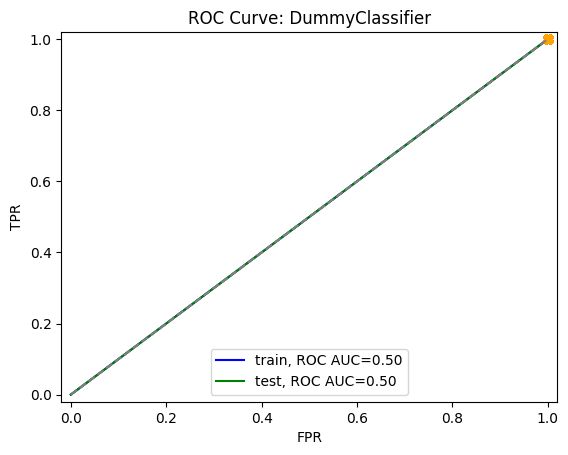

In [ ]:
dummy_metrics = evaluate_model("DummyClassifier", dummy, X_train, y_train, X_test, y_test)

### Logistic Regression (Stand-alone)

Let's start with the go-to classifier for this type of task: scikit-learn's [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [ ]:
%%time

logreg = LogisticRegression(random_state=5450, class_weight='balanced')

# parameters for GridSearch (refer to documentation for allowed penalty+solver combinations)
parameters = {'max_iter': [50, 100, 200], # default 100
                'solver': ('newton-cg', 'lbfgs', 'sag'), # lbfgs default | if resource intensive, remove newton-cg as it's more resource intensive
                'penalty': (None, 'l2' ) # l2 default
             }

logreg = GridSearchCV(estimator=logreg, param_grid=parameters, scoring='roc_auc')
logreg.fit(X_train, y_train)

CPU times: user 2min 10s, sys: 1min 14s, total: 3min 25s
Wall time: 29.9 s


GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          random_state=5450),
             param_grid={'max_iter': [50, 100, 200], 'penalty': (None, 'l2'),
                         'solver': ('newton-cg', 'lbfgs', 'sag')},
             scoring='roc_auc')

In [ ]:
#best params
logreg.best_params_

{'max_iter': 50, 'penalty': None, 'solver': 'lbfgs'}

          train  test
ROC AUC    0.69  0.69
Accuracy   0.64  0.64

Confusion Matrix:
[[10124  4981]
 [ 5973  9312]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.67      0.65     15105
           1       0.65      0.61      0.63     15285

    accuracy                           0.64     30390
   macro avg       0.64      0.64      0.64     30390
weighted avg       0.64      0.64      0.64     30390



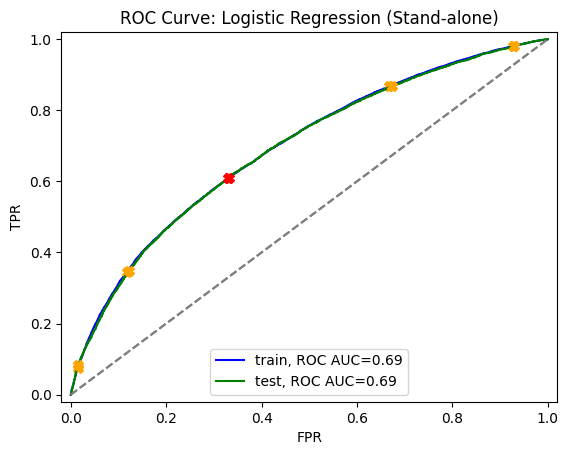

In [ ]:
logreg_metrics = evaluate_model("Logistic Regression (Stand-alone)", logreg, X_train, y_train, X_test, y_test)

### Logistic Regression (Pipeline)

For the model below, we will do a veriation that processes the data differently:
- Using scikit-learn's [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to apply scikit-learn's [StandardSaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) scaling only to numerical features and scikit-learn's [TdidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to text.
- Create a Pipeline with the Preprocessing from above and the classifier, which will still be the scikit-learn's [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)

*This model has a non-numeric feature so we will use the test data with suffix `_txt` denoting it includes the `text` column and it's unscaled.*

In [ ]:
df.columns

Index(['rating', 'text', 'verified_purchase', 'is_helpful', 'title_length',
       'text_length', 'is_blank_review', 'reviews_per_user',
       'has_variant_reviews', 'num_images', 'topic_0', 'topic_1', 'topic_2',
       'topic_3', 'topic_4', 'month_1.0', 'month_2.0', 'month_3.0',
       'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0', 'month_8.0',
       'month_9.0', 'dow_0.0', 'dow_1.0', 'dow_2.0', 'dow_3.0', 'dow_4.0',
       'dow_5.0', 'dow_6.0', 'product_category', 'brand', 'exclamations',
       'capital_letters', 'sentiment_polarity'],
      dtype='object')

In [ ]:
# Text feature extraction
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

# Preprocessing for numeric features
numeric_features = [col for col in df.columns if col not in ['text', 'is_helpful']] # all columns except 'text'
numeric_transformer = StandardScaler()

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('txt', tfidf, 'text')
    ])

In [ ]:
# skipping tuning
# logreg_pipe = LogisticRegression(random_state=5450, class_weight='balanced')

# # same as section above
# parameters = {'max_iter': [1000, 2000], # default 100 | warnings to "Increase the number of iterations (max_iter)"
#                 'solver': ('lbfgs', 'sag'), # lbfgs default | if resource intensive, remove newton-cg as it's more resource intensive
#                 'penalty': (None, 'l2' ) # l2 default
#              }

# logreg_pipe = GridSearchCV(estimator=logreg_pipe, param_grid=parameters, scoring='roc_auc')

# Create a pipeline with preprocessing and the classifier
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])

# Fit the model
clf.fit(X_train_txt, y_train_txt)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['rating',
                                                   'verified_purchase',
                                                   'title_length',
                                                   'text_length',
                                                   'is_blank_review',
                                                   'reviews_per_user',
                                                   'has_variant_reviews',
                                                   'num_images', 'topic_0',
                                                   'topic_1', 'topic_2',
                                                   'topic_3', 'topic_4',
                                                   'month_1.0', 'month_2.0',
                                                   'month_3.0', 'month_4.0',
                                                   'month_5.0', 'month_6.0',
                                                   'month_7.0', 'month_8.0',
                                                   'month_9.0', 'dow_0.0',
                                                   'dow_1.0', 'dow_2.0',
                                                   'dow_3.0', 'dow_4.0',
                                                   'dow_5.0', 'dow_6.0',
                                                   'product_category', ...]),
                                                 ('txt',
                                                  TfidfVectorizer(max_features=5000,
                                                                  stop_words='english'),
                                                  'text')])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

          train  test
ROC AUC    0.77  0.74
Accuracy   0.70  0.67

Confusion Matrix:
[[10263  4842]
 [ 5067 10218]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.68      0.67     15105
           1       0.68      0.67      0.67     15285

    accuracy                           0.67     30390
   macro avg       0.67      0.67      0.67     30390
weighted avg       0.67      0.67      0.67     30390



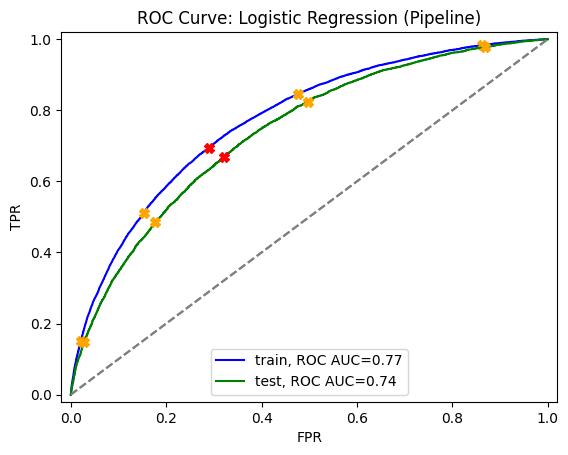

In [ ]:
clf_metrics = evaluate_model("Logistic Regression (Pipeline)", clf, X_train_txt, y_train_txt, X_test_txt, y_test_txt)

### Random Forest

We will use a decision tree via a scikit-learn's [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [ ]:
%%time

rforest = RandomForestClassifier(random_state=5450, class_weight='balanced')

# parameters for GridSearch (refer to documentation for allowed penalty+solver combinations)
parameters = {
             'n_estimators': [10, 30, 50], # default: 100
              'max_depth': [1, 2, 3], # default: None
              'criterion':['gini','entropy'], # default: gini
              'max_features':['auto','sqrt', 'log2'], # default: 'auto'
              'min_samples_leaf': [1, 2], # default: 1
              'min_samples_split': [2, 5] # default: 2
              }

rforest = GridSearchCV(estimator=rforest, param_grid=parameters, scoring='roc_auc')
rforest.fit(X_train, y_train)

/Users/rachelleperez/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
360 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rachelleperez/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rachelleperez/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/rachelleperez/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 666, in _validate_pa

CPU times: user 10min 7s, sys: 9.2 s, total: 10min 16s
Wall time: 10min 37s


GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=5450),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 30, 50]},
             scoring='roc_auc')

In [ ]:
#best params
rforest.best_params_


{'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 30}

          train  test
ROC AUC    0.69  0.69
Accuracy   0.64  0.63

Confusion Matrix:
[[9486 5619]
 [5478 9807]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.63      0.63     15105
           1       0.64      0.64      0.64     15285

    accuracy                           0.63     30390
   macro avg       0.63      0.63      0.63     30390
weighted avg       0.63      0.63      0.63     30390



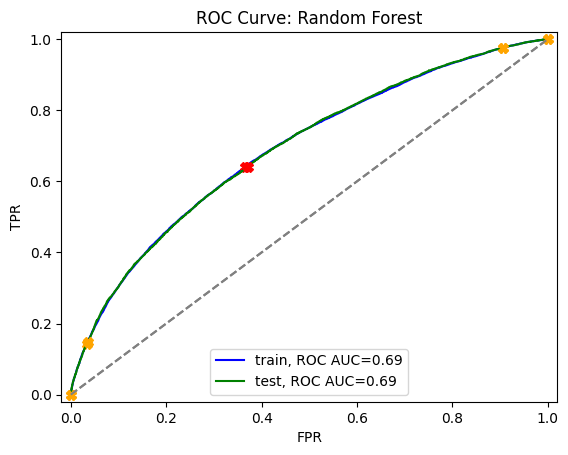

In [ ]:
rforest_metrics = evaluate_model("Random Forest", rforest, X_train, y_train, X_test, y_test)

### XGBoost

Out last model, [XGBoost](https://xgboost.readthedocs.io/en/stable/), will be a gradient boosting one. Classifier documentation [HERE](https://xgboost.readthedocs.io/en/stable/python/python_api.html).

In [ ]:
%%time

xg = XGBClassifier(objective='binary:logistic', max_depth=6, alpha=10, learning_rate=0.01, n_estimators=100)

# parameters for GridSearch (refer to documentation for allowed penalty+solver combinations)
parameters = {
    'max_depth': [3, 6],  #Default: 6
    'alpha': [0, 0.1],  # Default: 0
    'learning_rate': [0.01, 0.1], # Default: 0.3 | step size shrinkage used in update to prevent overfitting
    'n_estimators': [50, 100],  #  # Default: 100 | boosting rounds
              }

xg = GridSearchCV(estimator=xg, param_grid=parameters, scoring='roc_auc')
xg.fit(X_train, y_train)

CPU times: user 2min 26s, sys: 1min 11s, total: 3min 37s
Wall time: 19.5 s


GridSearchCV(estimator=XGBClassifier(alpha=10, base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0...ne,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=6,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'alpha': [0, 0.1], 'learning_rate': [0.01, 0.1],
                         'max_depth': [3, 6], 'n_estimators': [50, 100]},
             scoring='roc_auc')

In [ ]:
xg.best_params_

{'alpha': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}

          train  test
ROC AUC    0.78  0.75
Accuracy   0.70  0.68

Confusion Matrix:
[[10470  4635]
 [ 4948 10337]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.69      0.69     15105
           1       0.69      0.68      0.68     15285

    accuracy                           0.68     30390
   macro avg       0.68      0.68      0.68     30390
weighted avg       0.68      0.68      0.68     30390



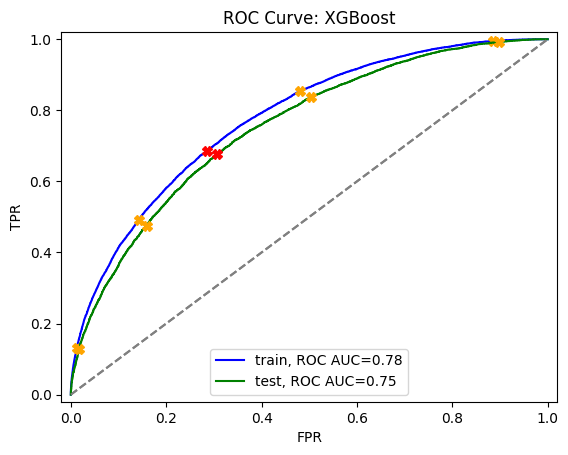

In [ ]:
xg_metrics = evaluate_model("XGBoost", xg, X_train, y_train, X_test, y_test)

In [ ]:
# Original XGBoost - opted for wrapped
# # import xgboost as xgb
# # from sklearn.metrics import f1_score, roc_auc_score

# # Assuming 'df' is your DataFrame and you've already processed 'text' and other columns
# X = df[['rating', 'verified_purchase', 'has_image']]
# y = df['is_helpful']

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the DMatrix
# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest = xgb.DMatrix(X_test, label=y_test)

# # Set up parameters for XGBoost
# params = {
#     'objective': 'binary:logistic',
#     'max_depth': 6,
#     'alpha': 10,
#     'learning_rate': 0.01,
#     'n_estimators': 100,
#     'eval_metric': 'auc'
# }

# # Adjusting the scale_pos_weight
# scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
# params['scale_pos_weight'] = scale_pos_weight

# # Train the model
# bst = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, 'test')], early_stopping_rounds=10)

# y_pred_prob = bst.predict(dtest)

# # Find the optimal threshold
# thresholds = np.linspace(0.01, 0.99, 100)
# scores = [f1_score(y_test, y_pred_prob > thresh) for thresh in thresholds]
# optimal_idx = np.argmax(scores)
# optimal_threshold = thresholds[optimal_idx]

# # Predict with the optimal threshold
# y_pred = (y_pred_prob > optimal_threshold).astype(int)

# # Calculate accuracy and other metrics
# accuracy = accuracy_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, y_pred_prob)
# conf_matrix = confusion_matrix(y_test, y_pred)
# class_report = classification_report(y_test, y_pred)

# print(f'Accuracy: {accuracy}')
# print(f'ROC AUC: {roc_auc}')
# print('Confusion Matrix:')
# print(conf_matrix)
# print('Classification Report:')
# print(class_report)


## Model Evaluation

So which of the models above was best?

In [ ]:
test_results = []

for results in [dummy_metrics, logreg_metrics, clf_metrics, rforest_metrics, xg_metrics]:
    test_results.append(results)

columns = ['name', 'roc_auc', 'accuracy']
test_results_df = pd.DataFrame(test_results,columns=columns)
# test_results_df['roc_auc_rank'] = test_results_df['roc_auc'].rank(ascending=False, method='min').astype('int32')
test_results_df

,name,roc_auc,accuracy
0,DummyClassifier,0.50,0.50
1,Logistic Regression (Stand-alone),0.69,0.64
2,Logistic Regression (Pipeline),0.74,0.67
3,Random Forest,0.69,0.63
4,XGBoost,0.75,0.68


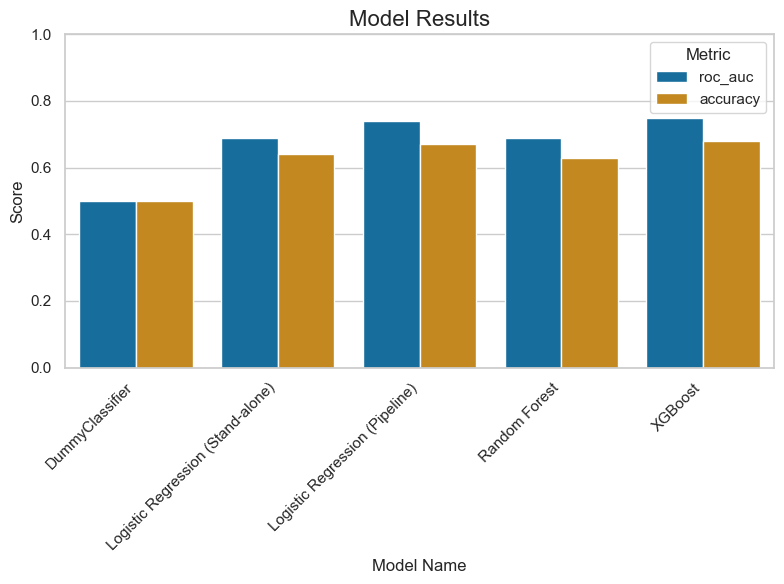

In [ ]:

melted_results_df = test_results_df.melt(id_vars='name', var_name='metric', value_name='score')

# Create the bar plot
plt.figure(figsize=(8, 6))

# Plot the scores
sns.set_context("notebook", font_scale=1.0)
standard_palette = "colorblind"

sns.barplot(data=melted_results_df, x='name', y='score', hue='metric', palette=standard_palette)
plt.xlabel('Model Name')
plt.ylabel('Score')
plt.title('Model Results', fontsize=16)
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Metric')
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

At the end, XGBoost performed the best followed by the Logic Regression, which actually arrives at a pretty respectable performance given the relatively sparse helpfulness data and extensive scope of the data space. We believe this may be a result of XG being better at handling non-linear data.

# Conclusion

The breadth and scope of Amazon data presents a number of challenges. Even de-scoping to a sample representing 2.5% of the available reviews, and these being themselves a small minority of the total available amazon review data, it is simply not possible to review a meaningful fraction of the data.

This is an extremely challenging problem!

Nevertheless, we believe we made several interesting discoveries.

First, a topic modelling approach (and likely other bag-of-words approaches) need to take into account that even subsets of the data will represent a huge span of products that are potentially very different. It may be necessary to tightly define scope on such approaches.

Second, a material part of review helpfulness is simply overall information density! The modelling results reflect the fact that users of reviews appear to have a preference (or at least chiefly express their appreciation) for higher effort reviews, and these can be powerful determinants of whether or not a review actually guides a purchase decision.

While our model is not sufficiently robust to guarantee high accuracy, it represents a good first effort, and we have identified a bunch of promising next steps, which we list here:

**Next Steps**

Some potential next steps for this project could include:
- Injesting a longer time span of reviews
- Consider other languages besides English
- Joining review data with available product data to consider the effect of other portions of the product page. For example, as the price increases is a review more likely to be markd helpful?
- Look at data at the reviewer level - perhaps the approach to address the problem could change to identifying the reviewers who leave helpful reviewes (to keep them engaged), instead of features of the reviews (although some of this would be sensitive information)
- Recreating or improving on the AI-assisted "Customers Say" meta review
